## Imports

In [1]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import missingno as msno
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
pd.set_option('display.max_columns', None)
from sktime.forecasting.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import seaborn as sns
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX as StatsmodelsSARIMAX
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
import random

In [2]:
#surpress warnings

warnings.filterwarnings("ignore")

In [185]:
random.seed(16)
tf.random.set_seed(42)

## Load data

In [4]:
def load_data(path):
    df = pd.read_csv(path, parse_dates=['datetime'])
    df = df.sort_index()
    columns_to_drop = ['Unnamed: 0', 'sunrise', 'sunset']
    df = df.drop(columns=columns_to_drop)
    df['datetime'] = pd.to_datetime(df['datetime'])

    last_year = df['datetime'].max() - pd.DateOffset(years=1)
    df_last_year = df[df['datetime'] >= last_year]
    df = df.sort_values('datetime')
    
    return df, df_last_year


In [5]:
df_london, df_last_year_london = load_data(r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\london_weather_2014-2024.csv')
df_manila, df_last_year_manila = load_data(r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\manila_weather_2014-2024.csv')


In [6]:
df_london.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,conditions,description,icon,stations
0,"London, England, United Kingdom",2014-01-01,11.6,6.7,9.1,11.6,3.6,7.0,6.7,84.8,11.857,100,16.67,rain,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0,NaN,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,EGWU,03680099999,03768399999,03672..."
1,"London, England, United Kingdom",2014-01-02,11.0,6.6,9.1,11.0,3.6,7.2,6.0,81.0,5.394,100,12.50,rain,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2,NaN,0.03,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03680099999,03672099999,0378109999..."
2,"London, England, United Kingdom",2014-01-03,10.6,7.3,9.0,10.6,3.2,6.5,5.1,76.8,6.030,100,16.67,rain,0.0,0.0,77.4,33.5,218.4,994.5,52.8,17.9,30.3,2.8,2,NaN,0.07,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,03680099999,03672099999,0378109999..."
3,"London, England, United Kingdom",2014-01-04,10.1,4.5,8.0,10.1,2.0,5.1,5.2,82.4,5.239,100,16.67,rain,0.0,0.0,62.1,29.2,206.0,993.6,67.6,22.0,17.4,1.4,1,NaN,0.10,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,03680099999,03672099999,0378109999..."
4,"London, England, United Kingdom",2014-01-05,12.0,1.8,6.0,12.0,-0.9,3.6,3.9,85.9,0.201,100,8.33,rain,0.0,0.0,55.6,30.4,192.5,1000.0,66.5,25.5,30.4,2.6,2,NaN,0.14,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03680099999,03672099999,0378109999..."


## Testing for stationarity of the data

As this is a time series comparative study, there is a need to understand the if the data is stationary. 

- https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/
- https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322?gi=334565268e20

In [7]:
def test_stationarity(df):
    result = adfuller(df)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print('TS is stationary')
    else:
        print('TS not stationary')

In [8]:
test_stationarity(df_london['temp'])

ADF Statistic: -3.826035220956989
p-value: 0.0026518953035616455
TS is stationary


In [9]:
# data is stationary therefore it will not be needing differantiation

## Descriptive statistics and EDA

In [10]:
def descriptive_stats(df):
    print("shape: ", df.shape)
    print("column headers: ", df.columns)
    print("first date in series: ", df_london['datetime'].min())
    print("last date in series: ", df_london['datetime'].max())
    print("minimum temperature: ", df_london['temp'].min())
    print("maximum temperature: ", df_london['temp'].max())
    print("missing data: ", df_london.isna().sum())
    print("descriptive statistics: ", df_london.describe())
    print("df info: ", df_london.info())
    print("number of missing values per column: ", df_london.isnull().sum())

In [11]:
descriptive_stats(df_london)

shape:  (3793, 31)
column headers:  Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase',
       'conditions', 'description', 'icon', 'stations'],
      dtype='object')
first date in series:  2014-01-01 00:00:00
last date in series:  2024-05-20 00:00:00
minimum temperature:  -3.2
maximum temperature:  30.3
missing data:  name                   0
datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
sno

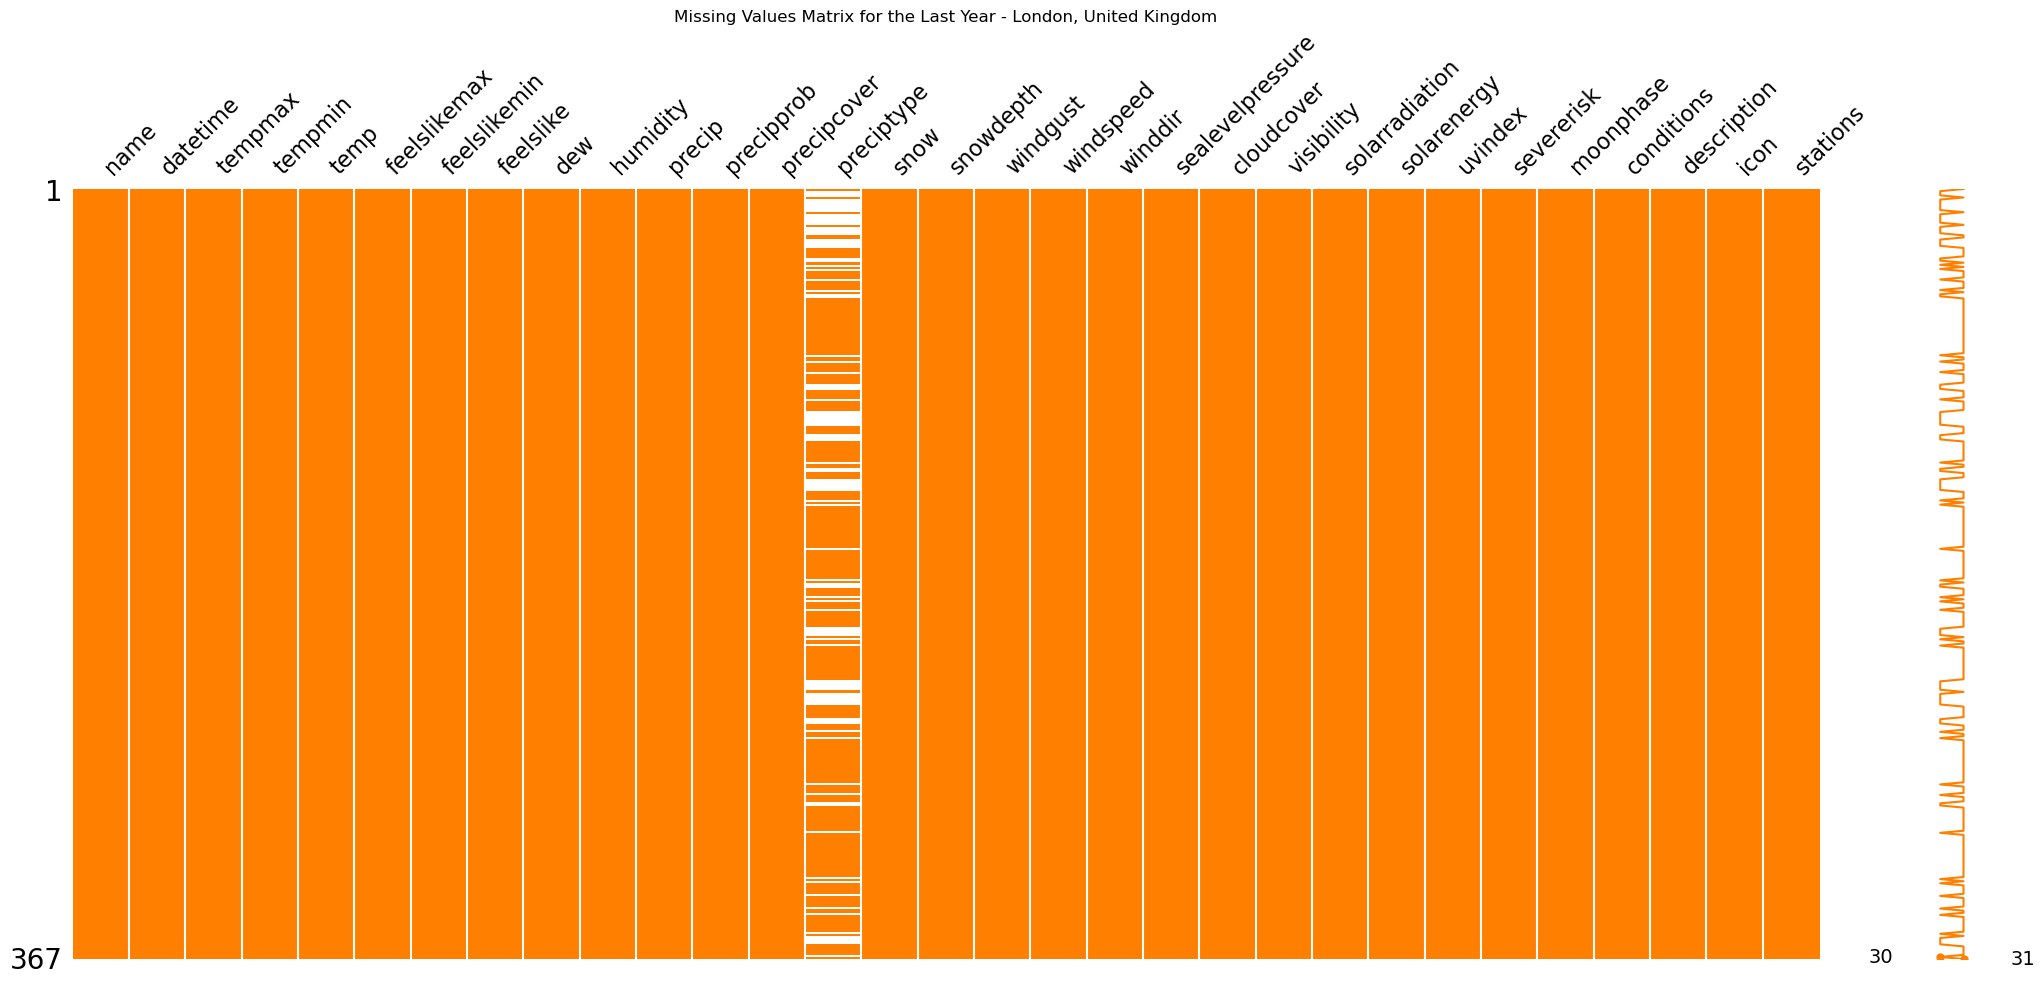

In [12]:
#checking for missing values

msno.matrix(df_last_year_london, color=(1.0, 0.5, 0.0))
plt.title('Missing Values Matrix for the Last Year - London, United Kingdom')

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\missing_values_matrix_london.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

<Figure size 1200x1000 with 0 Axes>

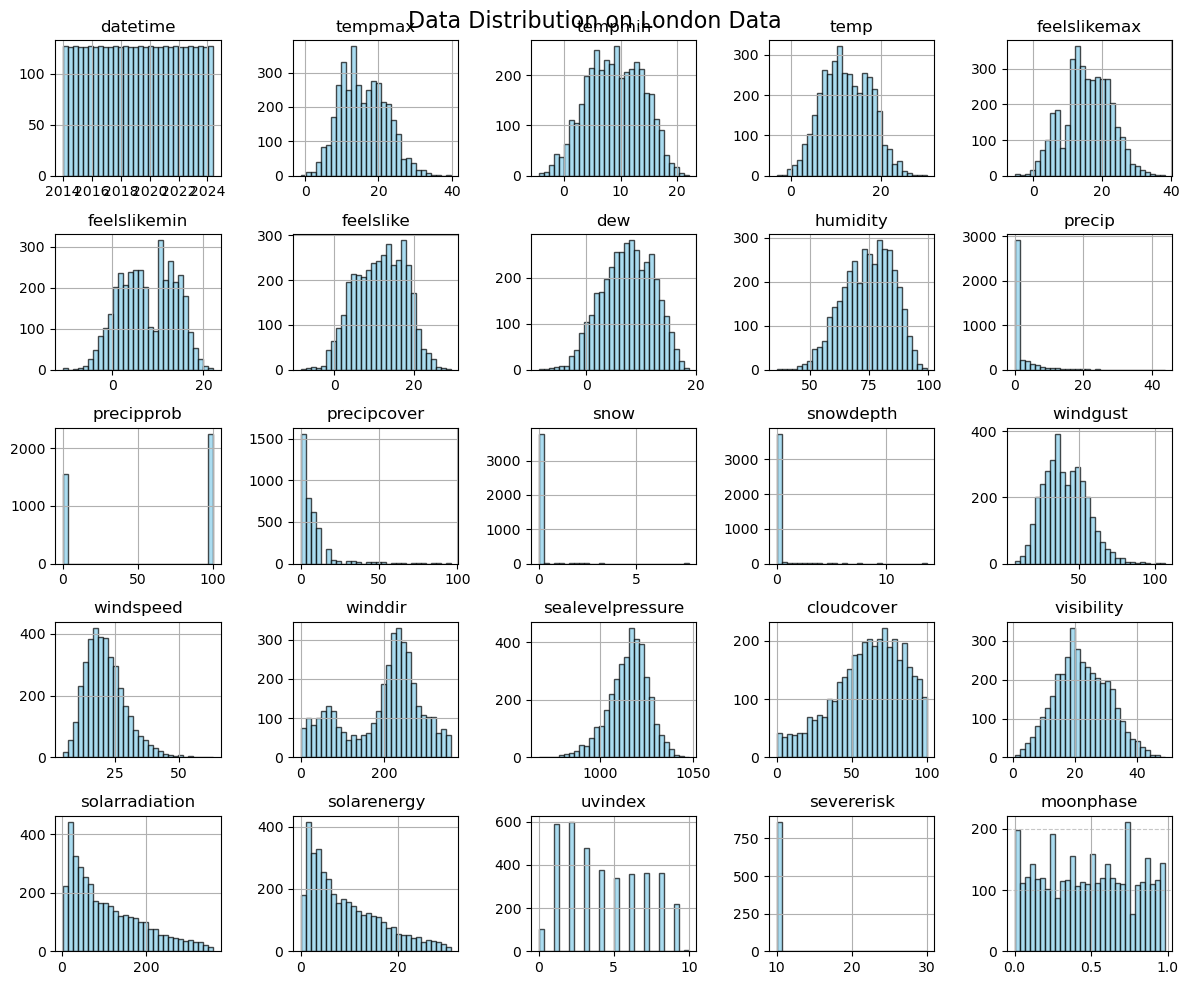

In [13]:
#checking data distribution
plt.figure(figsize=(12, 10))
df_london.hist(bins=30, color='skyblue', edgecolor='black', alpha=0.7, figsize=(12, 10))
plt.tight_layout()
plt.suptitle("Data Distribution on London Data", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\data-distribution-London.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 
plt.show()

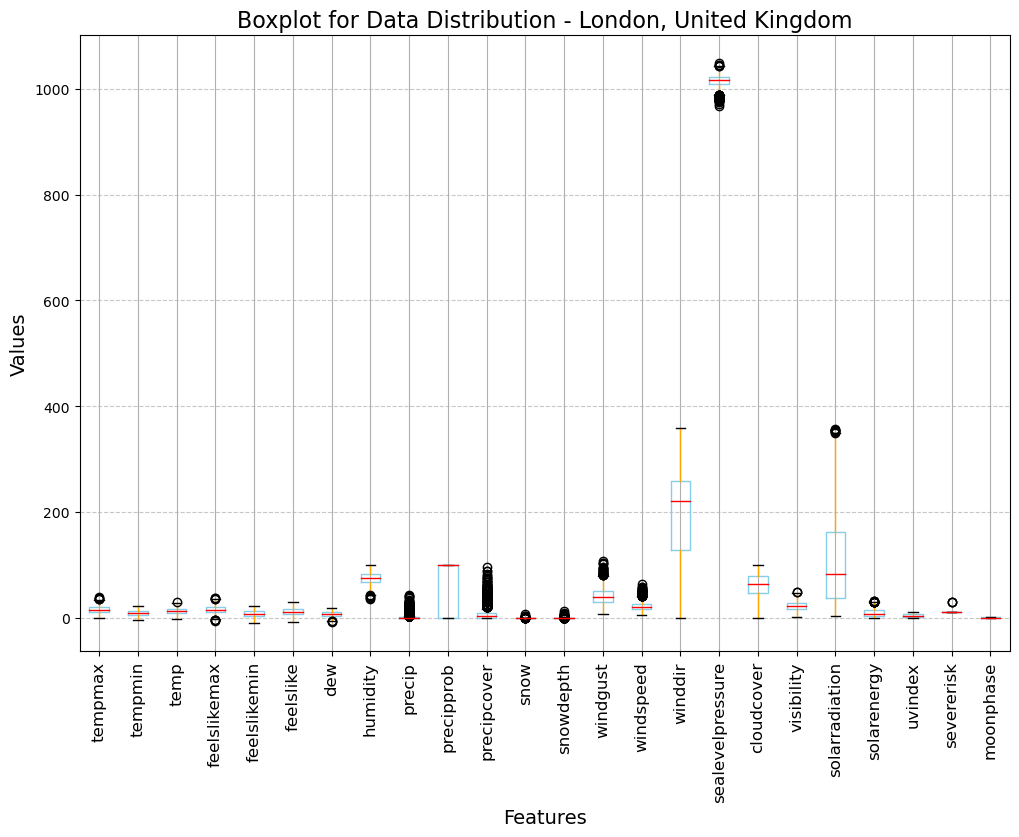

In [14]:
#data distribution
plt.figure(figsize=(12, 8))
df_london.boxplot(figsize=(12, 8), color={'boxes': 'skyblue', 'whiskers': 'orange', 'medians': 'red', 'caps': 'black'})
plt.xticks(rotation=90, fontsize=12)
plt.title('Boxplot for Data Distribution - London, United Kingdom', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\data-distribution2_london.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

In [15]:
#creating the correlation between features, for feature importance later on and heatmap
df_london_for_corr = df_london.drop(['name', 'preciptype', 'conditions','description','icon', 'stations'],axis=1)

In [16]:
df_london_for_corr.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
0,2014-01-01,11.6,6.7,9.1,11.6,3.6,7.0,6.7,84.8,11.857,100,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0,NaN,0.00
1,2014-01-02,11.0,6.6,9.1,11.0,3.6,7.2,6.0,81.0,5.394,100,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2,NaN,0.03
2,2014-01-03,10.6,7.3,9.0,10.6,3.2,6.5,5.1,76.8,6.030,100,16.67,0.0,0.0,77.4,33.5,218.4,994.5,52.8,17.9,30.3,2.8,2,NaN,0.07
3,2014-01-04,10.1,4.5,8.0,10.1,2.0,5.1,5.2,82.4,5.239,100,16.67,0.0,0.0,62.1,29.2,206.0,993.6,67.6,22.0,17.4,1.4,1,NaN,0.10
4,2014-01-05,12.0,1.8,6.0,12.0,-0.9,3.6,3.9,85.9,0.201,100,8.33,0.0,0.0,55.6,30.4,192.5,1000.0,66.5,25.5,30.4,2.6,2,NaN,0.14


In [17]:
corr_matrix = df_london_for_corr.corr()
print(corr_matrix) 

                  datetime   tempmax   tempmin      temp  feelslikemax  \
datetime          1.000000  0.008865  0.010205  0.007740      0.012812   
tempmax           0.008865  1.000000  0.880739  0.973772      0.992570   
tempmin           0.010205  0.880739  1.000000  0.956810      0.882454   
temp              0.007740  0.973772  0.956810  1.000000      0.970469   
feelslikemax      0.012812  0.992570  0.882454  0.970469      1.000000   
feelslikemin      0.010829  0.892497  0.984158  0.957931      0.897502   
feelslike         0.011530  0.966945  0.950490  0.992946      0.972603   
dew               0.025422  0.815229  0.919002  0.888771      0.826023   
humidity          0.047910 -0.510786 -0.295188 -0.433604     -0.484854   
precip            0.019130 -0.079772  0.028707 -0.037742     -0.072548   
precipprob       -0.058845 -0.235622 -0.062457 -0.167136     -0.222448   
precipcover       0.236525 -0.163003 -0.025887 -0.107080     -0.148046   
snow              0.007829 -0.115714 -

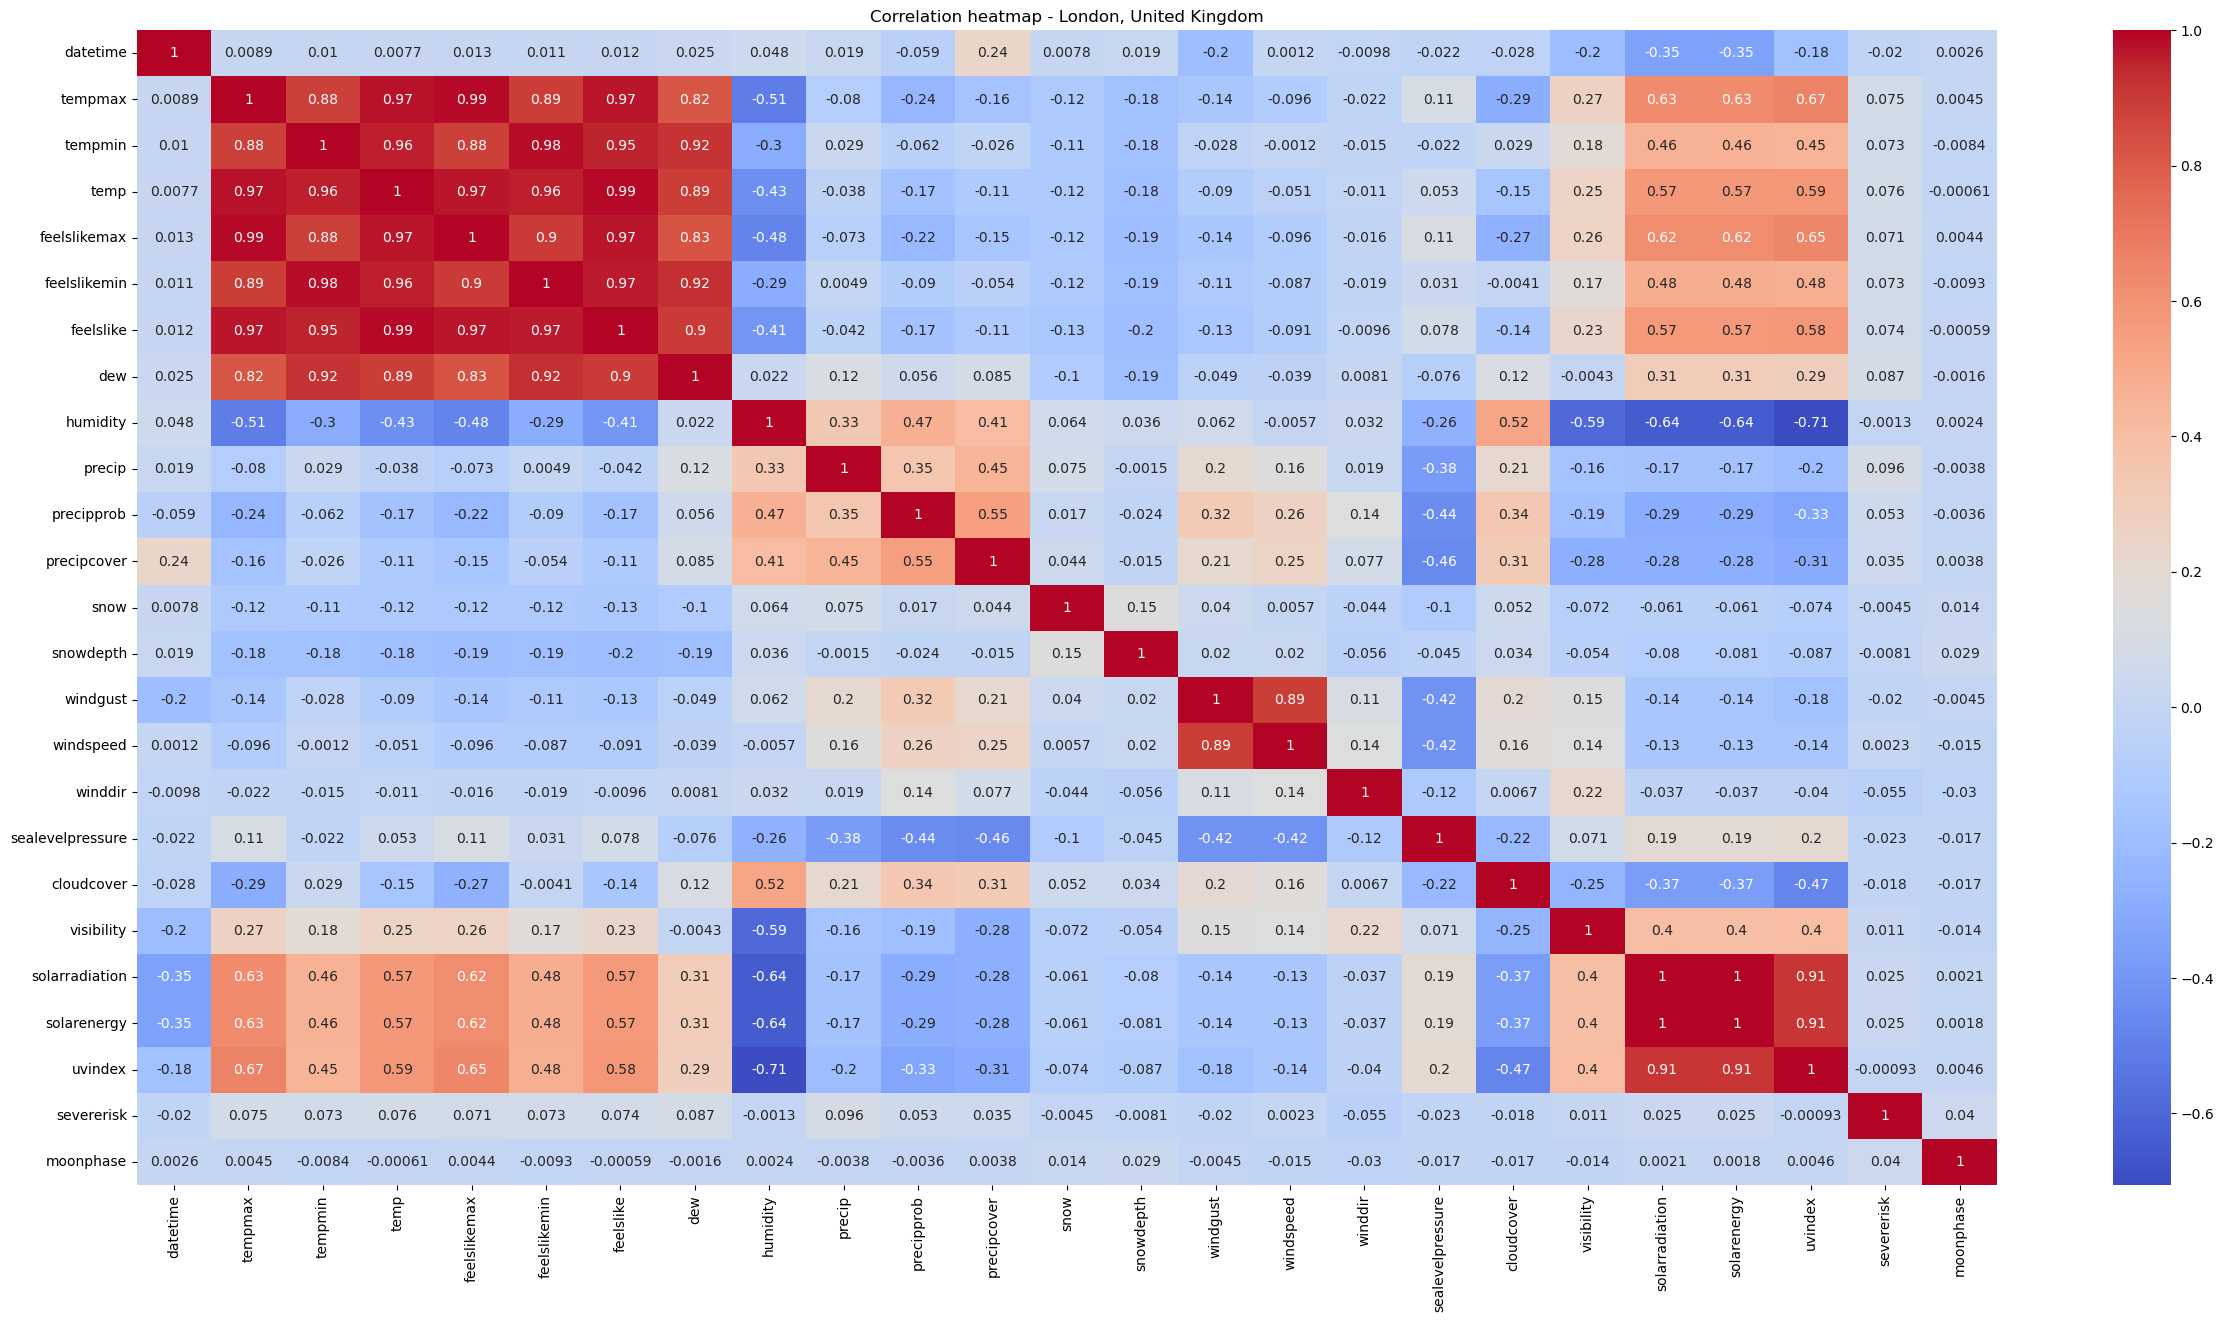

In [18]:
#heatmap

plt.figure(figsize=(30, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation heatmap - London, United Kingdom")

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\heatmap_london.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 


plt.show()

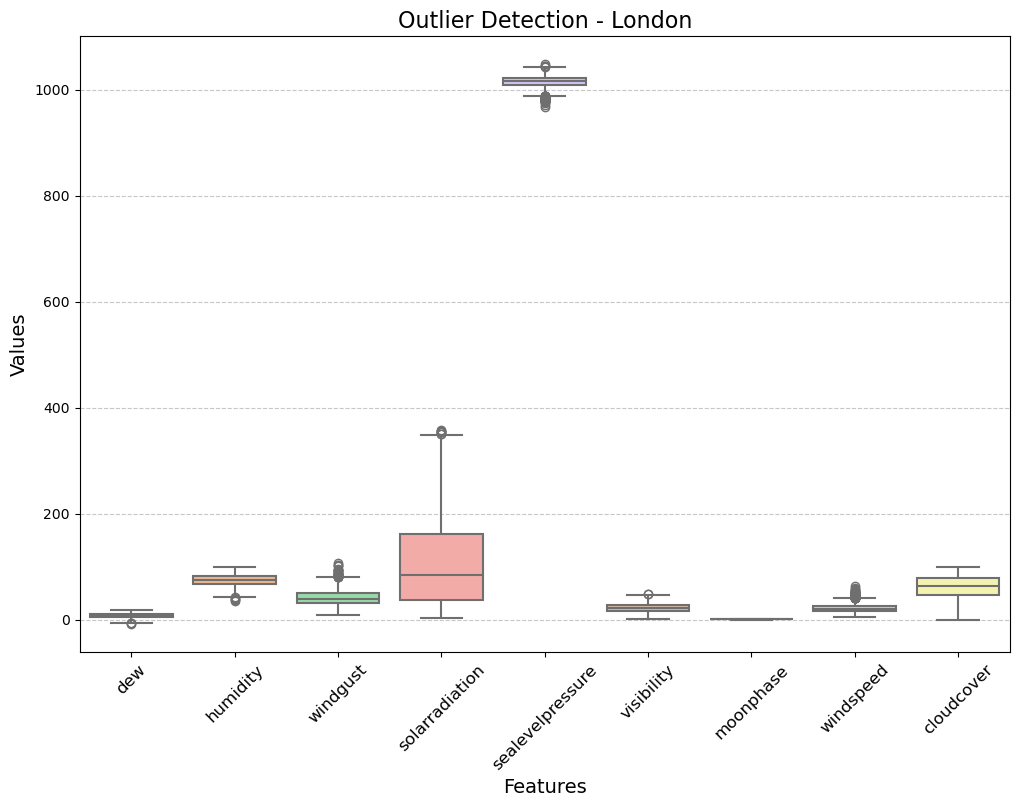

In [20]:
#checking for outliers

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_london[['dew', 'humidity', 'windgust', 'solarradiation', 'sealevelpressure', 'visibility','moonphase','windspeed','cloudcover']], 
             palette='pastel', linewidth=1.5)
plt.title("Outlier Detection - London", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\outlier_check_london.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

In [22]:
df_london.set_index("datetime", inplace = True)
df_london.sort_index(inplace = True)

In [23]:
df_london.head()

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,conditions,description,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,"London, England, United Kingdom",11.6,6.7,9.1,11.6,3.6,7.0,6.7,84.8,11.857,100,16.67,rain,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0,NaN,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,EGWU,03680099999,03768399999,03672..."
2014-01-02,"London, England, United Kingdom",11.0,6.6,9.1,11.0,3.6,7.2,6.0,81.0,5.394,100,12.50,rain,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2,NaN,0.03,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03680099999,03672099999,0378109999..."
2014-01-03,"London, England, United Kingdom",10.6,7.3,9.0,10.6,3.2,6.5,5.1,76.8,6.030,100,16.67,rain,0.0,0.0,77.4,33.5,218.4,994.5,52.8,17.9,30.3,2.8,2,NaN,0.07,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,03680099999,03672099999,0378109999..."
2014-01-04,"London, England, United Kingdom",10.1,4.5,8.0,10.1,2.0,5.1,5.2,82.4,5.239,100,16.67,rain,0.0,0.0,62.1,29.2,206.0,993.6,67.6,22.0,17.4,1.4,1,NaN,0.10,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,03680099999,03672099999,0378109999..."
2014-01-05,"London, England, United Kingdom",12.0,1.8,6.0,12.0,-0.9,3.6,3.9,85.9,0.201,100,8.33,rain,0.0,0.0,55.6,30.4,192.5,1000.0,66.5,25.5,30.4,2.6,2,NaN,0.14,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03680099999,03672099999,0378109999..."


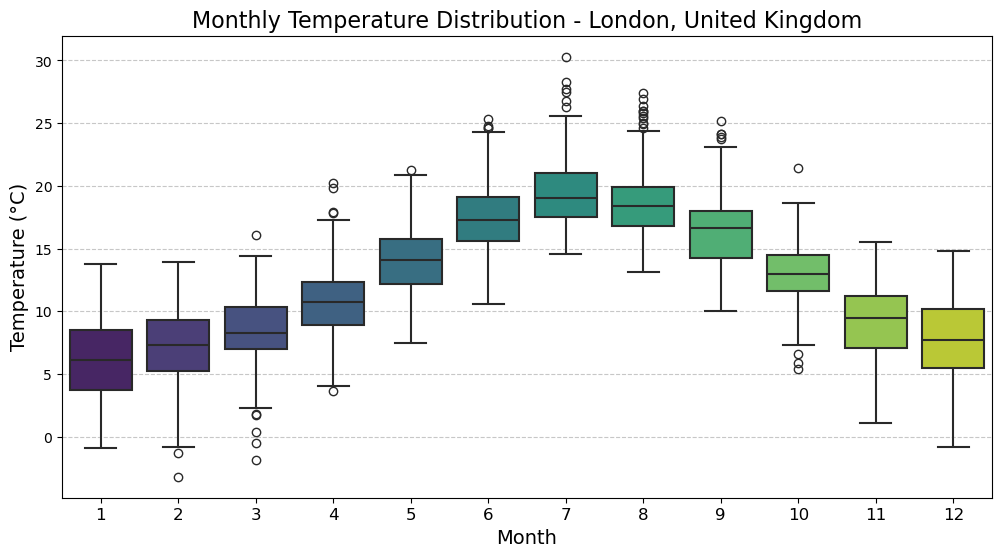

In [24]:
#understanding monthly distribution of the data and how the temperature differ from month to month

df_london['month'] = df_london.index.month

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temp', data=df_london, palette='viridis', linewidth=1.5)
plt.title('Monthly Temperature Distribution - London, United Kingdom', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\targetfeature_distribution_london.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 

plt.show()

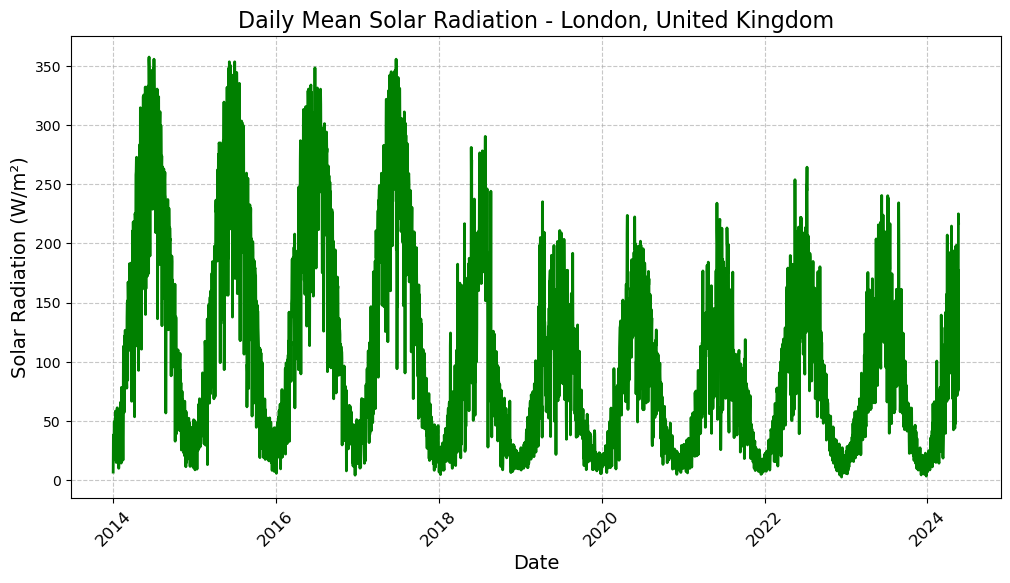

In [25]:
#looking to understand how the mean solar radiation is changing from year to year

daily_solar_radiation = df_london['solarradiation'].resample('D').mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_solar_radiation.index, daily_solar_radiation.values, linestyle='-', color='green', linewidth=2)
plt.title('Daily Mean Solar Radiation - London, United Kingdom', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Solar Radiation (W/m²)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\daily_mean_solarradiation-London.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 

plt.show()

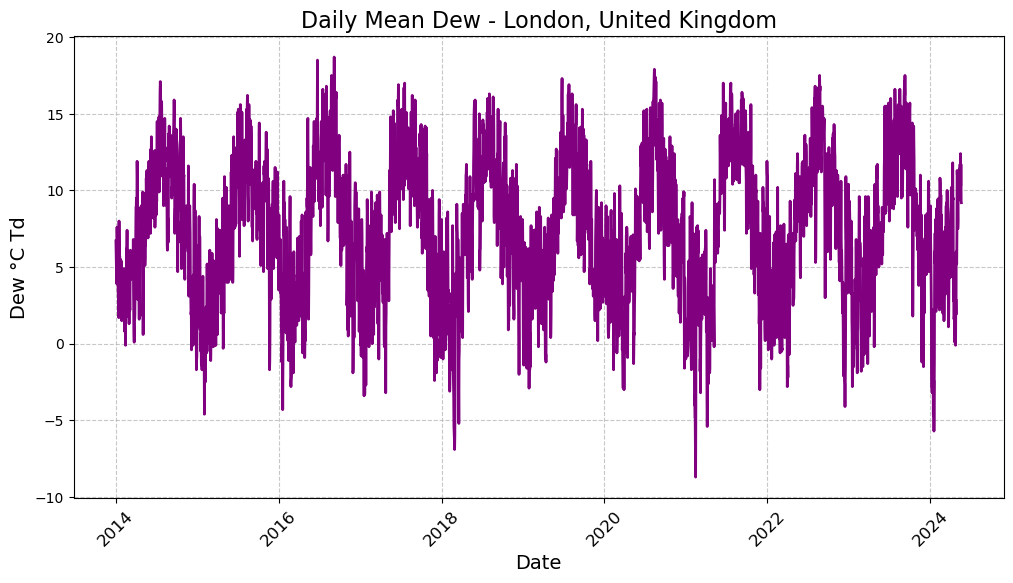

In [26]:
#looking to understand how the mean daily dew is changing from year to year

daily_dew = df_london['dew'].resample('D').mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_dew.index, daily_dew.values, linestyle='-', color='purple', linewidth=2)
plt.title('Daily Mean Dew - London, United Kingdom', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Dew °C Td', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\daily_mean_dew_london.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 

plt.show()

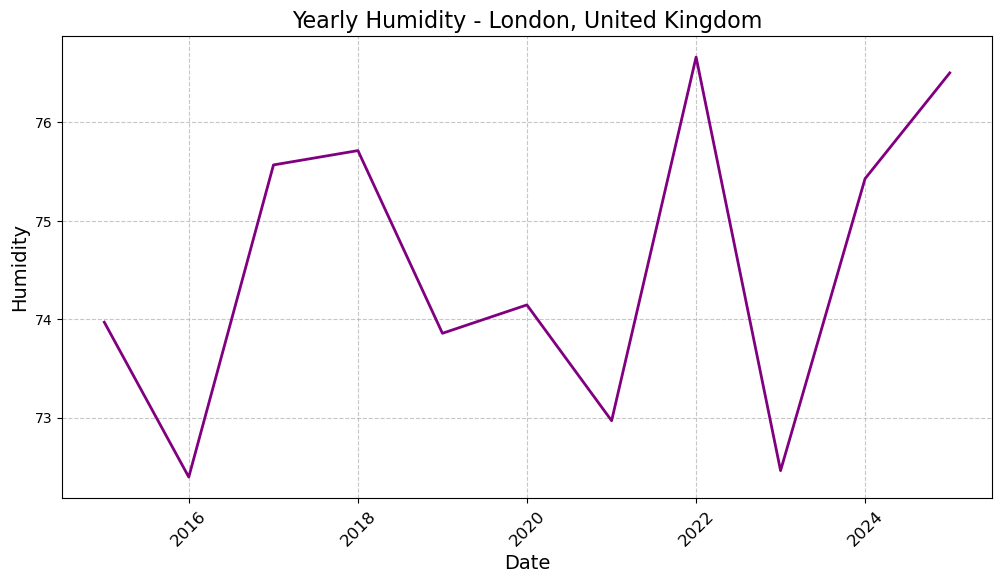

In [27]:
yearly_humidity = df_london['humidity'].resample('Y').mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_humidity.index, yearly_humidity.values, linestyle='-', color='purple', linewidth=2)
plt.title('Yearly Humidity - London, United Kingdom', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Humidity', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\yearly-humidity_london.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 

plt.show()

## Seasonal Decomposition

In [28]:
df_london.index = pd.to_datetime(df_london.index)

In [29]:
result = seasonal_decompose(df_london['temp'], model='additive', period=365)

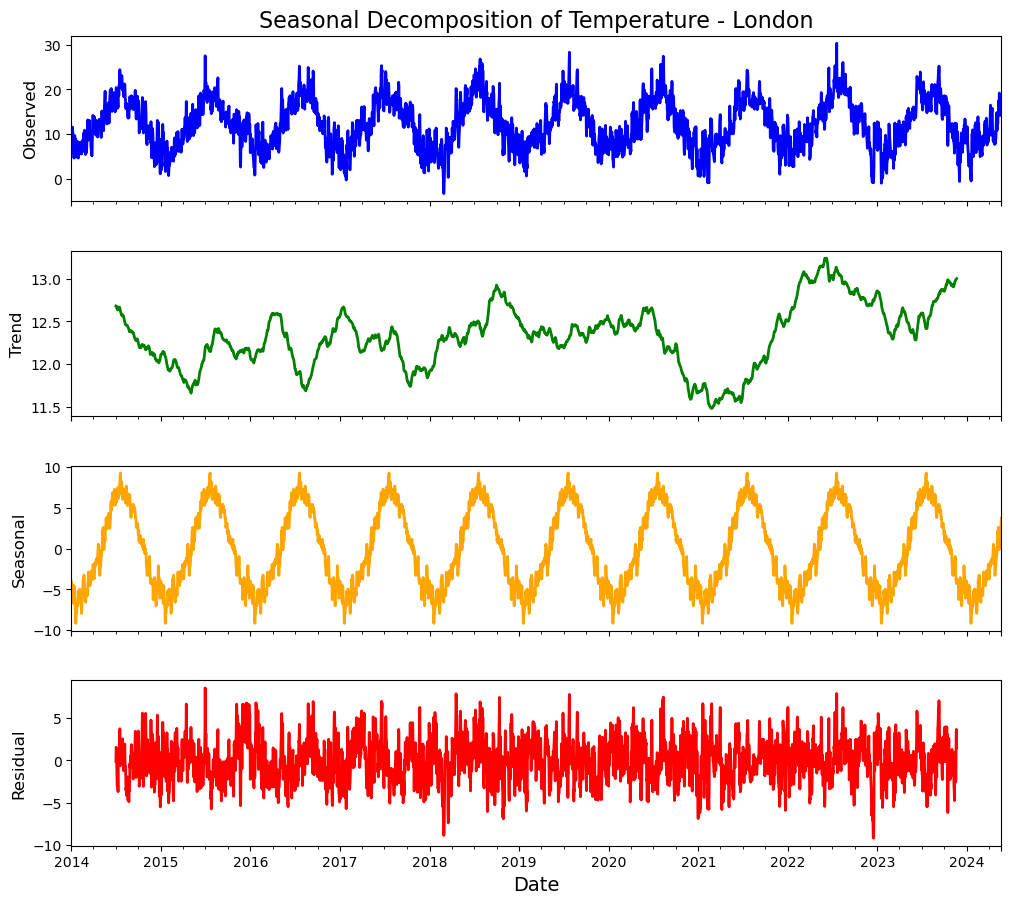

In [30]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)


result.observed.plot(ax=axes[0], color='blue', linewidth=2)
axes[0].set_ylabel('Observed', fontsize=12)
axes[0].set_title('Seasonal Decomposition of Temperature - London', fontsize=16)

result.trend.plot(ax=axes[1], color='green', linewidth=2)
axes[1].set_ylabel('Trend', fontsize=12)

result.seasonal.plot(ax=axes[2], color='orange', linewidth=2)
axes[2].set_ylabel('Seasonal', fontsize=12)

result.resid.plot(ax=axes[3], color='red', linewidth=2)
axes[3].set_ylabel('Residual', fontsize=12)
axes[3].set_xlabel('Date', fontsize=14)

plt.subplots_adjust(top=0.92, hspace=0.3)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\seasonal-decomposition_london.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 

plt.show()

## Missing values

In [31]:
df_london.isna().sum()

name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
snow                   0
snowdepth              0
windgust             175
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          2931
moonphase              0
conditions             0
description            0
icon                   0
stations               0
month                  0
dtype: int64

In [32]:
#run k-nn to fill in the missing values with the k nearest neighbour 
imputer = KNNImputer(n_neighbors=5)
df_london[['windgust', 'severerisk']] = imputer.fit_transform(df_london[['windgust', 'severerisk']])

In [33]:
df_london['preciptype'].unique()

array(['rain', nan, 'rain,snow', 'snow'], dtype=object)

In [34]:
df_london['preciptype'].value_counts()

preciptype
rain         2320
rain,snow      40
snow            7
Name: count, dtype: int64

In [35]:
df_london.isna().sum()

name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
snow                   0
snowdepth              0
windgust               0
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk             0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
month                  0
dtype: int64

In [36]:
#filling in missing values from precipitation because if they are missing, it means there was no registration of precipitation that day
df_london['preciptype'] = df_london['preciptype'].fillna(0)

In [37]:
df_london.isna().sum()

name                0
tempmax             0
tempmin             0
temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
preciptype          0
snow                0
snowdepth           0
windgust            0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
severerisk          0
moonphase           0
conditions          0
description         0
icon                0
stations            0
month               0
dtype: int64

## Droppping columns

In [38]:
# based on the heatmap, it seems that columns like tempmax, tempin, feelslikemax, feelslikemin and feelslike are too similar with the target variable and they are being dropped as to not create any data leakage in the models to follow

In [39]:
columns_to_drop = ['tempmax', 'tempmin', 'icon', 'stations', 'conditions', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'preciptype', 'name']
df_london = df_london.drop(columns=columns_to_drop)

## Tokenization of the "description" column

In [40]:
# adds columns in dataframe to let model know which conditions are most likely in one location

In [41]:
# step 1: text processing
tokenizer = CountVectorizer()
hashingTF = TfidfTransformer(use_idf=False)
idf = TfidfTransformer(use_idf=True)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

In [42]:
# pipeline that processes text and then clusters
pipeline = Pipeline(steps=[
    ('tokenizer', tokenizer),
    ('hashingTF', hashingTF),
    ('idf', idf),
    ('kmeans', kmeans)
])

In [43]:
# fitting the model on the "description"column
text_features = pipeline.fit_transform(df_london['description'])

In [44]:
kmeans.labels_
df_london['clusters_description'] = kmeans.labels_

In [45]:
df_london['clusters_description'].value_counts()

clusters_description
0    2309
1    1244
2     240
Name: count, dtype: int64

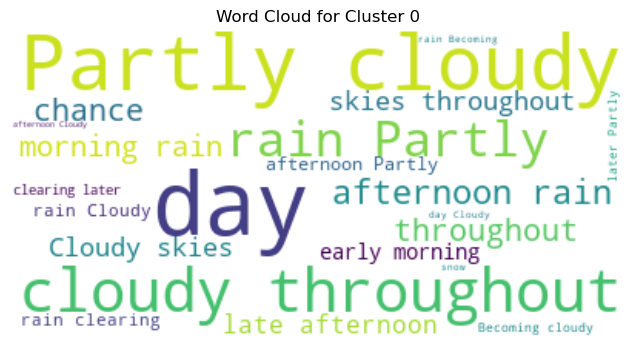

In [46]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==0]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 0')

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\wordcloud_cluster_0-London.png'
plt.savefig(save_path, bbox_inches='tight') 
plt.show()

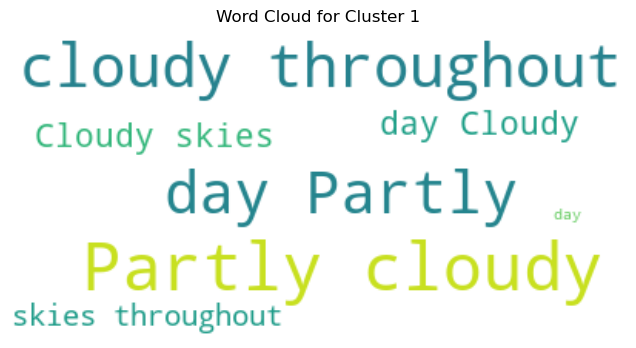

In [47]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==1]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 1')
save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\wordcloud_cluster_1)lodon.png'
plt.savefig(save_path, bbox_inches='tight') 
plt.show()

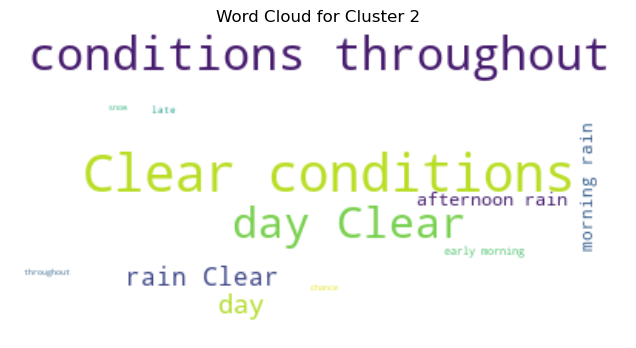

In [48]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==2]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 2')
save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\wordcloud_cluster_2-London.png'
plt.savefig(save_path, bbox_inches='tight') 
plt.show()

In [49]:
df_london = df_london.drop(columns=['description'])
df_london.head(5)

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,month,clusters_description
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01,9.1,6.7,84.8,11.857,100,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0,10.0,0.00,1,0
2014-01-02,9.1,6.0,81.0,5.394,100,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2,10.0,0.03,1,0
2014-01-03,9.0,5.1,76.8,6.030,100,16.67,0.0,0.0,77.4,33.5,218.4,994.5,52.8,17.9,30.3,2.8,2,10.0,0.07,1,0
2014-01-04,8.0,5.2,82.4,5.239,100,16.67,0.0,0.0,62.1,29.2,206.0,993.6,67.6,22.0,17.4,1.4,1,10.0,0.10,1,0
2014-01-05,6.0,3.9,85.9,0.201,100,8.33,0.0,0.0,55.6,30.4,192.5,1000.0,66.5,25.5,30.4,2.6,2,10.0,0.14,1,0


## Lagged features

In [50]:
#shifting the features by 3 days

In [51]:
# this shifts all features by three days except the temp, and then it merges them back togther
df_london_shifted = df_london.drop('temp', axis=1).shift(3)

In [52]:
df_london_eng = pd.concat([df_london['temp'], df_london_shifted], axis=1)

In [53]:
df_london_eng.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,month,clusters_description
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,8.0,6.7,84.8,11.857,100.0,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0.0,10.0,0.00,1.0,0.0
2014-01-05,6.0,6.0,81.0,5.394,100.0,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2.0,10.0,0.03,1.0,0.0


In [54]:
df_london_shifted.head()

,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,month,clusters_description
datetime,,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,6.7,84.8,11.857,100.0,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0.0,10.0,0.00,1.0,0.0
2014-01-05,6.0,81.0,5.394,100.0,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2.0,10.0,0.03,1.0,0.0


In [55]:
# adding back the last three rows, which have all the shifted features but without the temp for them as that is what we predict
last_three = df_london_shifted.tail(3)
last_three.set_index( pd.date_range(start=max(df_london.index)+pd.Timedelta(days=1), periods=3, freq='D'))


,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,month,clusters_description
2024-05-21,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,5.0,0.0
2024-05-22,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,5.0,0.0
2024-05-23,10.3,70.2,0.000,0.0,0.00,0.0,0.0,17.4,9.4,194.8,1009.3,41.4,21.7,177.8,15.5,10.0,10.0,0.30,5.0,1.0


In [56]:
max(df_london.index)+pd.Timedelta(days=1)

Timestamp('2024-05-21 00:00:00')

In [57]:
df_london_final = pd.concat([df_london_eng, last_three], ignore_index=True)

In [58]:
df_london_final = df_london_final.set_index(pd.date_range(start=min(df_london.index), periods=len(df_london)+3, freq='D'))

In [59]:
df_london_final.tail()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,month,clusters_description
2024-05-19,16.6,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,5.0,0.0
2024-05-20,15.1,10.3,70.2,0.000,0.0,0.00,0.0,0.0,17.4,9.4,194.8,1009.3,41.4,21.7,177.8,15.5,10.0,10.0,0.30,5.0,1.0
2024-05-21,NaN,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,5.0,0.0
2024-05-22,NaN,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,5.0,0.0
2024-05-23,NaN,10.3,70.2,0.000,0.0,0.00,0.0,0.0,17.4,9.4,194.8,1009.3,41.4,21.7,177.8,15.5,10.0,10.0,0.30,5.0,1.0


In [60]:
# I created three new dates with all the lagged features aside from temp, which will be predicted in the next section

## Train and test split 

In [61]:
# done based on the date as it's a time series

In [62]:
# because XGBoost is not a time series model, i will split the datetime column into days, months and year, so the model can learn which temperature is related to the May month and which temperature is related to the December month, as it learns accross multiple years

In [63]:
df_london_final['month'] = df_london_final.index.month
df_london_final['year'] = df_london_final.index.year

In [64]:
df_dummies = pd.get_dummies(df_london_final['month'], prefix='month')

In [65]:
df_london_final = pd.concat([df_london_final, df_dummies], axis=1)
df_london_final.drop(columns=['month'], inplace=True)

In [66]:
df_london_final.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2014-01-01,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-02,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-03,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-04,8.0,6.7,84.8,11.857,100.0,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0.0,10.0,0.00,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-05,6.0,6.0,81.0,5.394,100.0,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2.0,10.0,0.03,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False


In [67]:
df_train = df_london_final.iloc[:-368] #training set - takes the last 368 days
df_test = df_london_final.iloc[-368:-3] #test set - takes the last 368 - the last 3 days for preds
df_future =  df_london_final.iloc[-3:] #future dataframe that contains the predictions that we will generate but right now has just the features

In [68]:
df_train.head()
df_train.dropna(inplace=True)

## 1. XGBOOST 

### 1.1 Baseline model

In [69]:
start_time = time.time()
model_baseline = XGBRegressor()
model_baseline.fit(df_train.drop('temp',axis=1), df_train[['temp']])
end_time = time.time()

#calculates the time taken for each model to compute
#will be applied to all models
time_xgboost_baseline = end_time - start_time
print(f"Model execution time for XGBoost baseline: {time_xgboost_baseline:.4f} seconds")

Model execution time for XGBoost baseline: 0.3347 seconds


In [70]:
y_pred_xgboost = model_baseline.predict(df_test.drop('temp',axis=1))

In [71]:
y_pred_xgboost

array([14.492051 , 17.870735 , 16.441523 , 14.017682 , 13.3807955,
       18.364727 , 13.875509 , 16.55626  , 13.40738  , 17.022013 ,
       13.096956 , 15.220464 , 18.718847 , 16.462023 , 17.883986 ,
       18.190876 , 18.983713 , 15.292368 , 13.434772 , 16.804014 ,
       17.765388 , 17.663021 , 17.780577 , 18.162876 , 19.35969  ,
       16.947762 , 18.929035 , 15.666152 , 18.354177 , 16.387234 ,
       18.575077 , 16.272154 , 17.615025 , 20.331121 , 17.903595 ,
       20.021744 , 19.140293 , 18.134293 , 19.111702 , 21.45441  ,
       19.583147 , 20.168015 , 18.224314 , 18.75007  , 18.87896  ,
       17.913774 , 16.178864 , 18.172672 , 20.501274 , 21.236399 ,
       20.726442 , 20.156572 , 17.11704  , 16.378408 , 17.71087  ,
       18.798628 , 16.771502 , 17.329672 , 16.65339  , 17.572655 ,
       19.383886 , 20.404385 , 20.10089  , 18.238998 , 17.524273 ,
       17.880363 , 16.556747 , 16.61994  , 17.54138  , 18.602844 ,
       16.800179 , 17.26145  , 17.58127  , 16.794807 , 18.3065

In [72]:
has_na = np.isnan(y_pred_xgboost).any()
print({has_na})

{False}


In [73]:
na_count = np.isnan(y_pred_xgboost).sum()
print({na_count})

{0}


In [74]:
df_test.isna()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2023-05-22,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-23,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-24,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-25,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-26,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-05-17,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-05-18,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-05-19,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### 1.2 Performance metrics for XGBOOST baseline

In [75]:
mae = mean_absolute_error(df_test['temp'], y_pred_xgboost)
mse = mean_squared_error(df_test['temp'], y_pred_xgboost)
rmse = mse ** 0.5
r2 = r2_score(df_test['temp'], y_pred_xgboost)

print(f"Mean Absolute Error (MAE) for XGBoost baseline with all regressors: {mae}")
print(f"Mean Squared Error (MSE) for XGBoost baseline with all regressors: {mse}")
print(f"Root Mean Squared Error (RMSE) for XGBoost baseline with all regressors: {rmse}")
print(f"R-squared (R2) for XGBoost baseline with all regressors: {r2}")

Mean Absolute Error (MAE) for XGBoost baseline with all regressors: 2.3868065674664227
Mean Squared Error (MSE) for XGBoost baseline with all regressors: 8.827414221743139
Root Mean Squared Error (RMSE) for XGBoost baseline with all regressors: 2.971096467929498
R-squared (R2) for XGBoost baseline with all regressors: 0.6797312280993014


In [76]:
# for RMSE: if my prediction is errored I want that to inflate the error - but don't know in which direction
# MAE: it means it's 2.3 degrees away from truth just don't know in which direction 

### 1.3 XGBOOST baseline predictions vs actuals

In [77]:
df_test[['temp']]

,temp
2023-05-22,15.1
2023-05-23,14.0
2023-05-24,15.8
2023-05-25,15.0
2023-05-26,14.2
...,...
2024-05-16,14.2
2024-05-17,16.4
2024-05-18,15.8
2024-05-19,16.6


In [78]:
df_test_w_preds = df_test.copy()

In [79]:
#create new column in order to attach index date to the preds
df_test_w_preds['preds'] = y_pred_xgboost

In [80]:
def plot_forecast(actuals, predictions, model_name, save_path=None):
    plt.figure(figsize=(15, 10))

    plt.plot(actuals, label='Actuals', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2)
    plt.plot(predictions, label='Predictions', color='orange', marker='s', markersize=5, linestyle='-', linewidth=2)

    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Temperature', fontsize=14)
    plt.title(f'Predicted vs Actual Temperature - {model_name} - London', fontsize=16)

    plt.grid(True)
    plt.legend(fontsize=12)

    if save_path is not None:
        plt.savefig(f"{save_path}/{model_name}_predictions.png", bbox_inches='tight', dpi=300)

    plt.show()

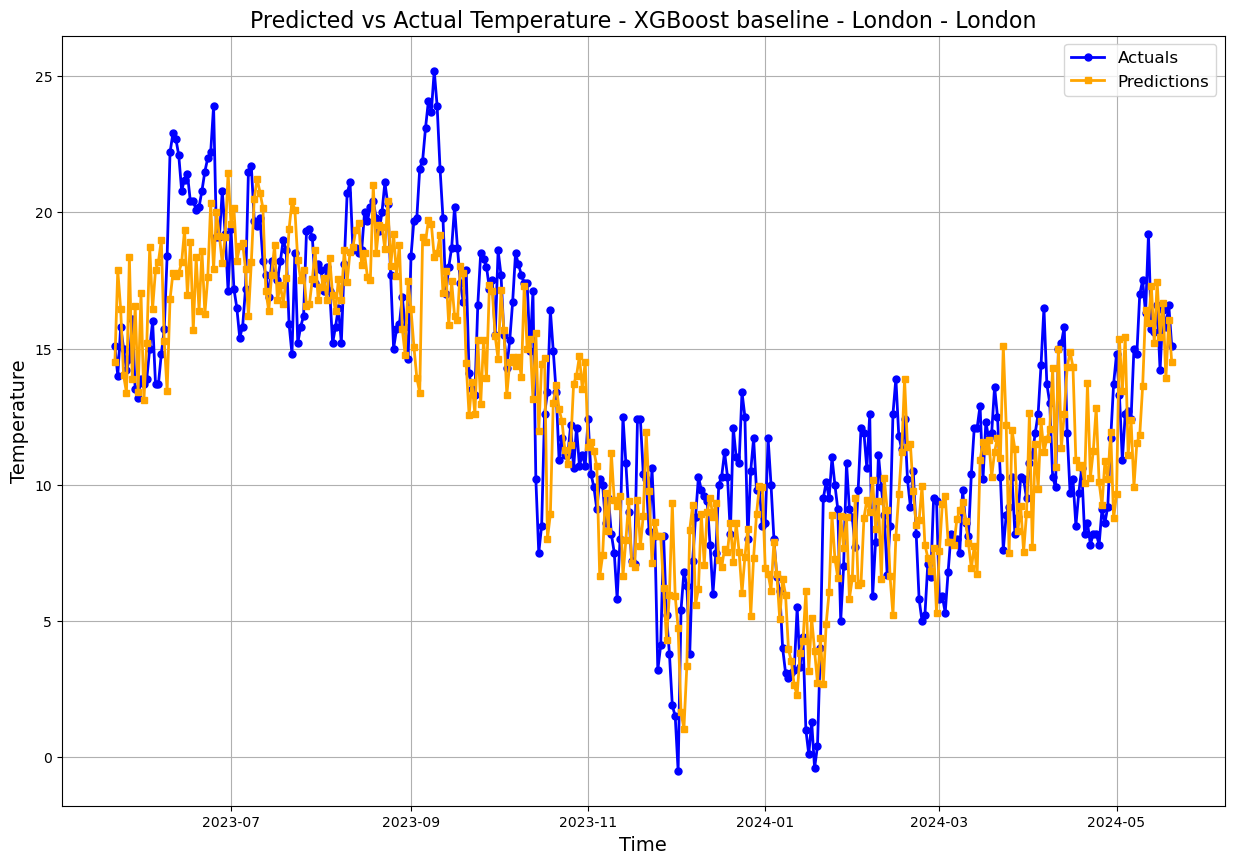

In [81]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds']], 'XGBoost baseline - London', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 1.4 Feature importance

<Figure size 1200x800 with 0 Axes>

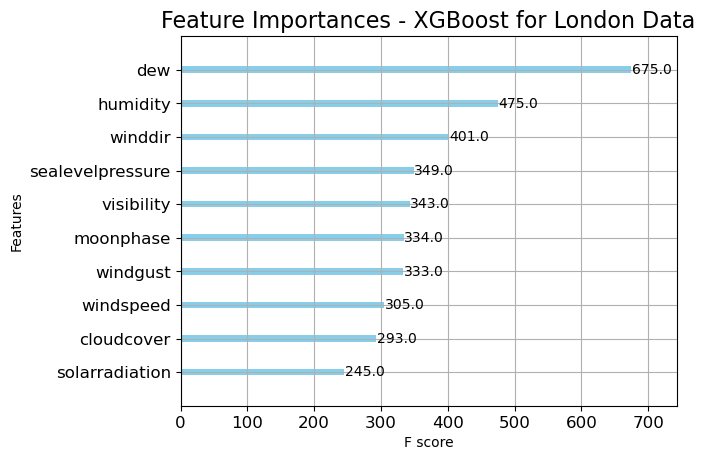

In [82]:
plt.figure(figsize=(12, 8))
plot_importance(model_baseline, 
                importance_type='weight', 
                max_num_features=10, 
                title='Feature Importances - XGBoost for London Data', 
                xlabel='F score', 
                ylabel='Features', 
                grid=True,
                color='skyblue')

plt.title('Feature Importances - XGBoost for London Data', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\feature_importance_london.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

In [84]:
future_preds = model_baseline.predict(df_future.drop('temp', axis=1))

In [85]:
df_future['preds'] = future_preds

In [86]:
df_future

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds
2024-05-21,NaN,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,13.906611
2024-05-22,NaN,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.043221
2024-05-23,NaN,10.3,70.2,0.000,0.0,0.00,0.0,0.0,17.4,9.4,194.8,1009.3,41.4,21.7,177.8,15.5,10.0,10.0,0.30,1.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,14.519270


### 1.5 XGBOOST GS

In [87]:
df_train.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2014-01-04,8.0,6.7,84.8,11.857,100.0,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0.0,10.0,0.00,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-05,6.0,6.0,81.0,5.394,100.0,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2.0,10.0,0.03,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-06,11.6,5.1,76.8,6.030,100.0,16.67,0.0,0.0,77.4,33.5,218.4,994.5,52.8,17.9,30.3,2.8,2.0,10.0,0.07,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-07,10.7,5.2,82.4,5.239,100.0,16.67,0.0,0.0,62.1,29.2,206.0,993.6,67.6,22.0,17.4,1.4,1.0,10.0,0.10,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-08,9.6,3.9,85.9,0.201,100.0,8.33,0.0,0.0,55.6,30.4,192.5,1000.0,66.5,25.5,30.4,2.6,2.0,10.0,0.14,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False


In [88]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'max_leaf_nodes':  [0, 10, 20], 
    'reg_lambda': [0, 0.1, 1]
}

grid_search = GridSearchCV(estimator=model_baseline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [89]:
start_time = time.time()
grid_search.fit(df_train.drop('temp', axis=1), df_train['temp']) #first one is train without target, second one is just target

best_params = grid_search.best_params_
best_score = grid_search.best_score_
end_time = time.time()


time_xgboost_gs = end_time - start_time
print(f"Model execution time for XGBoost grid search: {time_xgboost_gs:.4f} seconds")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Model execution time for XGBoost grid search: 23.8379 seconds


In [90]:
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 0, 'reg_lambda': 1, 'subsample': 0.7}
Best score: -7.226425704507559


In [91]:
gs_model = XGBRegressor(learning_rate= 0.1, max_depth= 3, subsample= 0.7, max_leaf_nodes=0, reg_lambda=1)
gs_model.fit(df_train.drop('temp',axis=1), df_train[['temp']])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaf_nodes=0,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [92]:
y_pred_xgboost_gs = gs_model.predict(df_test.drop('temp',axis=1))

### 1.6 XGBOOST GS performance metrics

In [93]:
mae = mean_absolute_error(df_test['temp'], y_pred_xgboost_gs)
mse = mean_squared_error(df_test['temp'], y_pred_xgboost_gs)
rmse = mse ** 0.5
r2 = r2_score(df_test['temp'], y_pred_xgboost_gs)

print(f"Mean Absolute Error (MAE) for GS model: {mae}")
print(f"Mean Squared Error (MSE) for GS model: {mse}")
print(f"Root Mean Squared Error (RMSE) for GS model: {rmse}")
print(f"R-squared (R2) for XGBoost baseline GS model: {r2}")

Mean Absolute Error (MAE) for GS model: 2.1030320937012976
Mean Squared Error (MSE) for GS model: 7.130397327265726
Root Mean Squared Error (RMSE) for GS model: 2.6702803836424605
R-squared (R2) for XGBoost baseline GS model: 0.7413009588309011


In [94]:
df_test_w_preds['preds_gs'] = y_pred_xgboost_gs

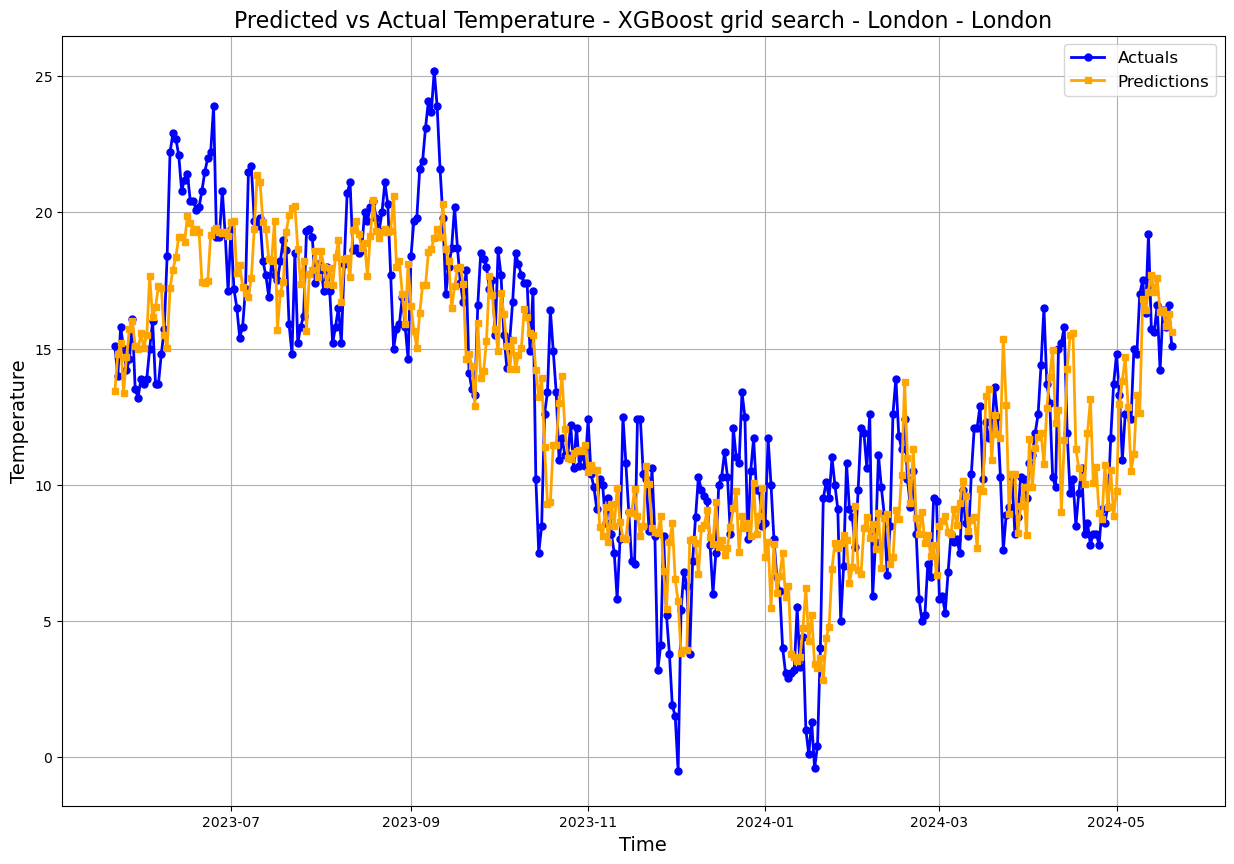

In [95]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds_gs']], 'XGBoost grid search - London', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

## 2. Naive Forecaster (Sktime)

### 2.1 Baseline model

In [96]:
start_time = time.time()

forecaster_baseline = NaiveForecaster(strategy="mean")
forecaster_baseline.fit(df_train['temp'])

end_time = time.time()
time_naive_baseline = end_time - start_time
print(f"Model execution time for Naive Forecaster baseline: {time_naive_baseline:.4f} seconds")

Model execution time for Naive Forecaster baseline: 0.0030 seconds


In [97]:
y_pred_naiveforecaster = forecaster_baseline.predict(df_test.index)

In [98]:
y_pred_naiveforecaster

2023-05-22    12.189839
2023-05-23    12.189839
2023-05-24    12.189839
2023-05-25    12.189839
2023-05-26    12.189839
                ...    
2024-05-16    12.189839
2024-05-17    12.189839
2024-05-18    12.189839
2024-05-19    12.189839
2024-05-20    12.189839
Freq: D, Name: temp, Length: 365, dtype: float64

In [99]:
df_test_w_preds['sktime_naive'] = y_pred_naiveforecaster

In [100]:
df_test_w_preds.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive
2023-05-22,15.1,6.9,64.3,0.0,0.0,0.0,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,12.189839
2023-05-23,14.0,6.1,60.6,0.0,0.0,0.0,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,12.189839
2023-05-24,15.8,6.7,61.2,0.0,0.0,0.0,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,12.189839
2023-05-25,15.0,6.7,57.9,0.0,0.0,0.0,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,12.189839
2023-05-26,14.2,6.9,63.5,0.0,0.0,0.0,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,12.189839


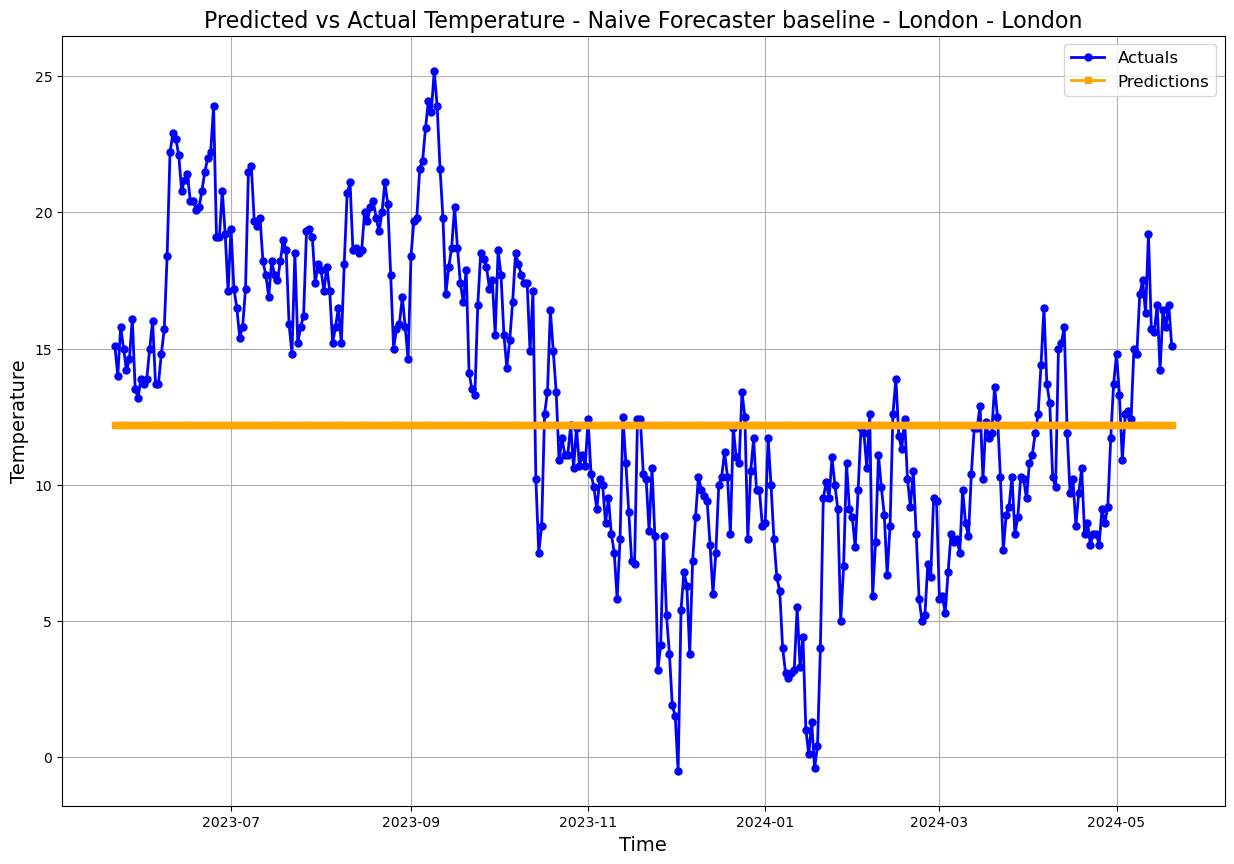

In [101]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['sktime_naive']], 'Naive Forecaster baseline - London', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 2.2 Naive Forecaster performance metrics

In [102]:
mae = mean_absolute_error(df_test['temp'], y_pred_naiveforecaster)
mse = mean_squared_error(df_test['temp'], y_pred_naiveforecaster)
rmse = np.sqrt(mse)
r2 = r2_score(df_test['temp'], y_pred_naiveforecaster)

print(f"Mean Absolute Error (MAE) for the Naive Forecaster: {mae}")
print(f"Mean Squared Error (MSE) for the Naive Forecaster: {mse}")
print(f"Root Mean Squared Error (RMSE) for the Naive Forecaster: {rmse}")
print(f"R-squared (R²) for the Naive Forecaster: {r2}")

Mean Absolute Error (MAE) for the Naive Forecaster: 4.4214064993500655
Mean Squared Error (MSE) for the Naive Forecaster: 28.21710502528725
Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.311977506097635
R-squared (R²) for the Naive Forecaster: -0.023749123586186638


### 2.3 Naive Forecaster GS

In [103]:
# only one parameter to tune - strategy

In [104]:
def tune_naive(strategy): 
    start_time = time.time()
    forecaster_baseline = NaiveForecaster(strategy=strategy)
    forecaster_baseline.fit(df_train['temp'])
    y_pred_naiveforecaster_gs = forecaster_baseline.predict(df_test.index)
    df_test_w_preds['sktime_naive'] = y_pred_naiveforecaster_gs
    mae = mean_absolute_error(df_test['temp'], y_pred_naiveforecaster_gs)

    mse = mean_squared_error(df_test['temp'], y_pred_naiveforecaster_gs)
    rmse = np.sqrt(mse)
    r2 = r2_score(df_test['temp'], y_pred_naiveforecaster_gs)

    print(f"{strategy}, Mean Absolute Error (MAE) for the Naive Forecaster: {mae}")
    print(f"{strategy}, Mean Squared Error (MSE) for the Naive Forecaster: {mse}")
    print(f"{strategy}, Root Mean Squared Error (RMSE) for the Naive Forecaster: {rmse}")
    print(f"{strategy}, R-squared (R²) for the Naive Forecaster: {r2}")
    end_time = time.time()
    time_naive_gs = end_time - start_time
    print(f"Model execution time: {time_naive_gs:.4f} seconds")

### 2.4. Naive Forecaster GS performance metrics

In [105]:
tune_naive("mean")

mean, Mean Absolute Error (MAE) for the Naive Forecaster: 4.4214064993500655
mean, Mean Squared Error (MSE) for the Naive Forecaster: 28.21710502528725
mean, Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.311977506097635
mean, R-squared (R²) for the Naive Forecaster: -0.023749123586186638
Model execution time: 0.0140 seconds


In [106]:
tune_naive("last")

last, Mean Absolute Error (MAE) for the Naive Forecaster: 4.561643835616438
last, Mean Squared Error (MSE) for the Naive Forecaster: 29.52558904109589
last, Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.433745397154333
last, R-squared (R²) for the Naive Forecaster: -0.07122243324038968
Model execution time: 0.0194 seconds


In [107]:
tune_naive("drift")

drift, Mean Absolute Error (MAE) for the Naive Forecaster: 4.736848034822686
drift, Mean Squared Error (MSE) for the Naive Forecaster: 31.844905375476948
drift, Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.643129041186011
drift, R-squared (R²) for the Naive Forecaster: -0.15536990558079733
Model execution time: 0.0220 seconds


In [108]:
# the "last" strategy had the best result so the predictions will be included in the df with all predictions 
y_pred_naiveforecaster_gs = forecaster_baseline.predict(df_test.index)
df_test_w_preds['sktime_naive'] = y_pred_naiveforecaster_gs

df_test_w_preds[f'naive_last'] = y_pred_naiveforecaster_gs

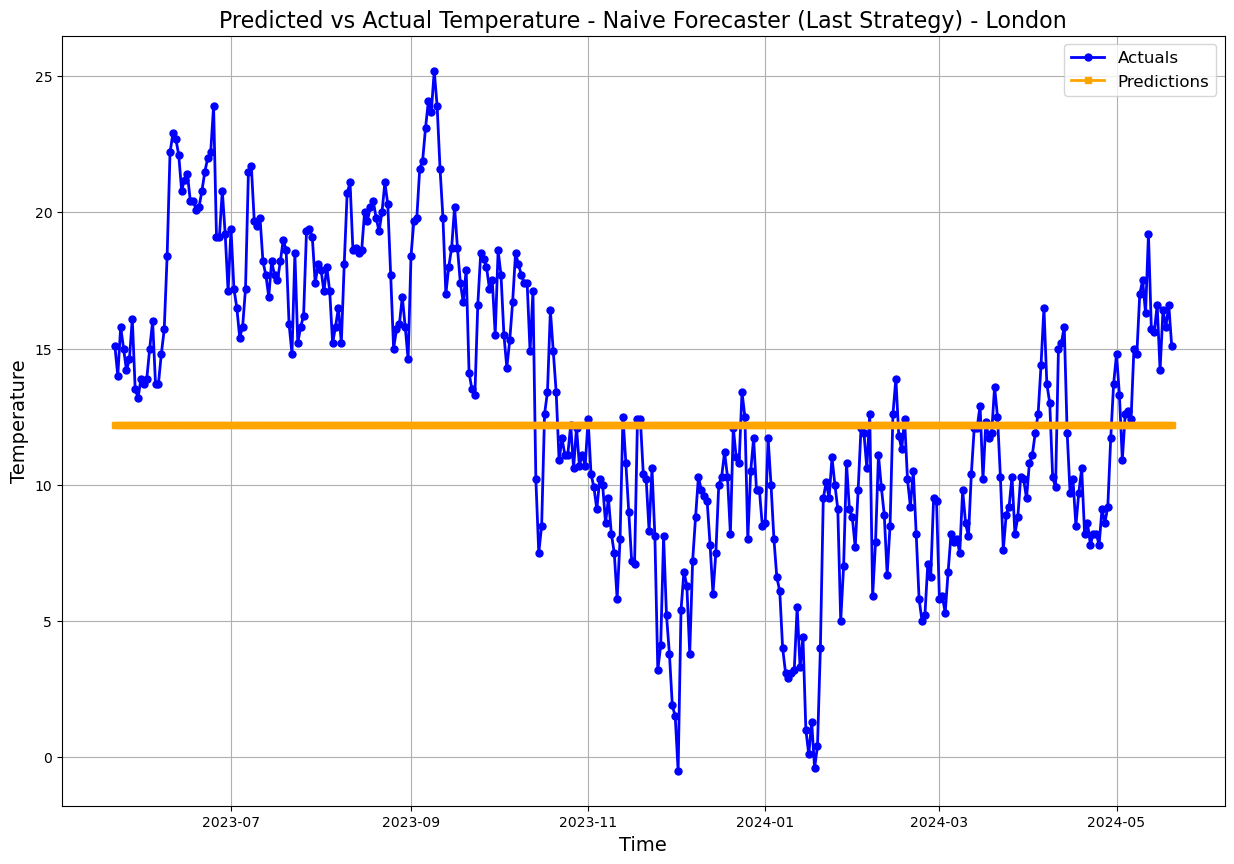

In [109]:
plt.figure(figsize=(15, 10))
plt.plot(df_test['temp'], label='Actuals', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2)
plt.plot(y_pred_naiveforecaster_gs, label='Predictions', color='orange', marker='s', markersize=5, linestyle='-', linewidth=2)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.title('Predicted vs Actual Temperature - Naive Forecaster (Last Strategy) - London', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

## 3. AUTO ARIMA

In [110]:
df_train_short = df_train[df_train.index > pd.to_datetime('2021-01-01')]

In [111]:
start_time = time.time()

forecaster_arima = AutoARIMA(sp=12, suppress_warnings=True)
forecaster_arima.fit(df_train_short['temp'])

end_time = time.time()
time_autoarima_baseline = end_time - start_time
print(f"Model execution time for Auto ARIMA: {time_autoarima_baseline:.4f} seconds")

Model execution time for Auto ARIMA: 68.5472 seconds


In [112]:
y_pred_autoarima = forecaster_arima.predict(df_test.index)

In [113]:
y_pred_autoarima

2023-05-22    13.984044
2023-05-23    13.895126
2023-05-24    13.759057
2023-05-25    13.725513
2023-05-26    13.632718
                ...    
2024-05-16    13.488740
2024-05-17    13.489218
2024-05-18    13.488746
2024-05-19    13.489213
2024-05-20    13.488752
Freq: D, Name: temp, Length: 365, dtype: float64

In [114]:
df_test_w_preds['preds_autoarima'] = y_pred_autoarima
df_test_w_preds

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive,naive_last,preds_autoarima
2023-05-22,15.1,6.9,64.3,0.000,0.0,0.00,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,12.189839,12.189839,13.984044
2023-05-23,14.0,6.1,60.6,0.000,0.0,0.00,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,12.189839,12.189839,13.895126
2023-05-24,15.8,6.7,61.2,0.000,0.0,0.00,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,12.189839,12.189839,13.759057
2023-05-25,15.0,6.7,57.9,0.000,0.0,0.00,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,12.189839,12.189839,13.725513
2023-05-26,14.2,6.9,63.5,0.000,0.0,0.00,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,12.189839,12.189839,13.632718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16,14.2,11.0,73.4,0.000,0.0,0.00,0.0,0.0,35.2,21.0,183.4,1007.1,86.1,14.9,71.5,6.2,2.0,10.0,0.17,1.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,15.429116,16.348656,12.189839,12.189839,13.488740
2024-05-17,16.4,11.7,77.8,3.598,100.0,33.33,0.0,0.0,30.5,21.0,149.7,1001.1,85.6,15.4,76.1,6.5,4.0,10.0,0.20,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.688347,16.409649,12.189839,12.189839,13.489218
2024-05-18,15.8,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,13.906611,15.812546,12.189839,12.189839,13.488746
2024-05-19,16.6,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.043221,16.279257,12.189839,12.189839,13.489213


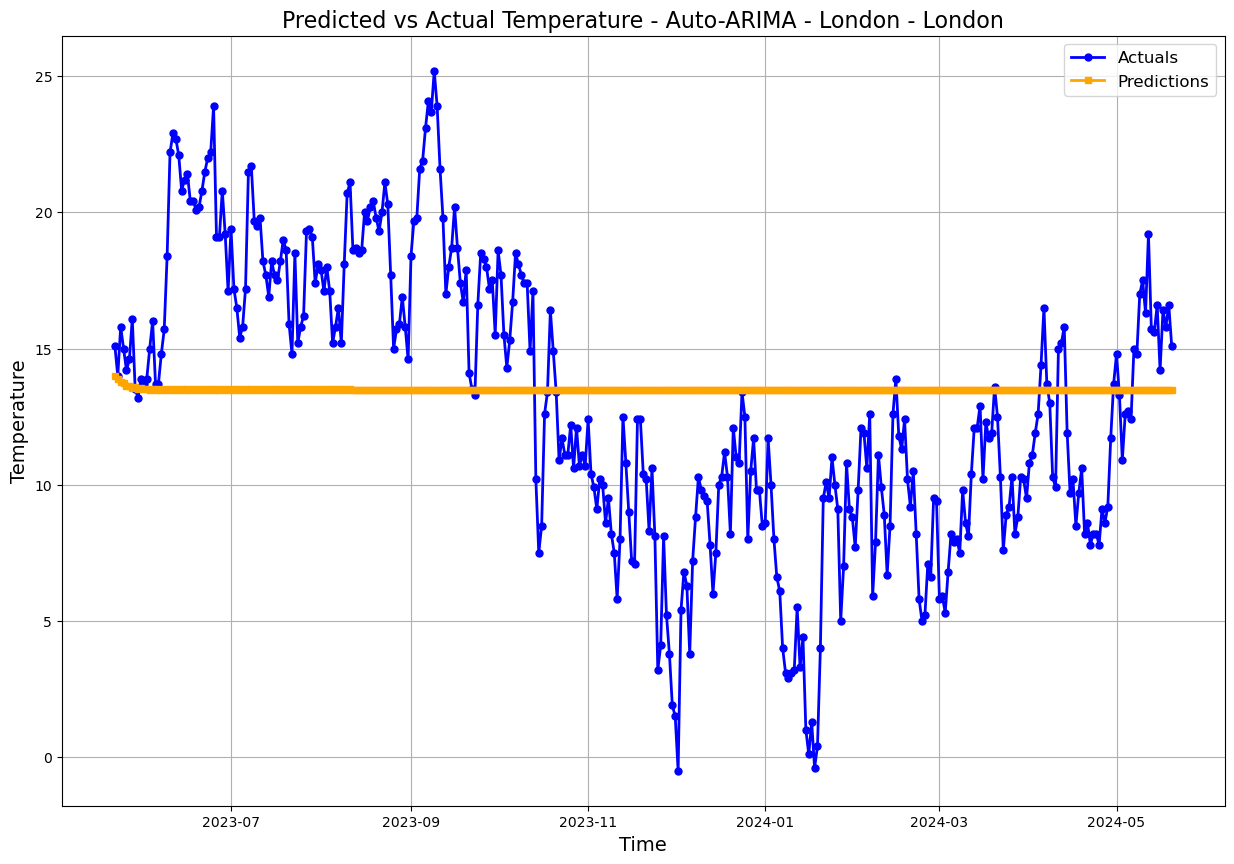

In [115]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds_autoarima']], 'Auto-ARIMA - London', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 3.1 AUTO ARIMA performance metrics

In [116]:
mae = mean_absolute_error(df_test['temp'],y_pred_autoarima)
mse = mean_squared_error(df_test['temp'],y_pred_autoarima)
rmse = np.sqrt(mse)
r2 = r2_score(df_test['temp'], y_pred_autoarima)

print(f"Mean Absolute Error (MAE) for AUTO-ARIMA: {mae}")
print(f"Mean Squared Error (MSE) for AUTO-ARIMA: {mse}")
print(f"Root Mean Squared Error (RMSE) for AUTO-ARIMA: {rmse}")
print(f"R-squared (R²) for AUTO-ARIMA: {r2}") 

Mean Absolute Error (MAE) for AUTO-ARIMA: 4.44099364415425
Mean Squared Error (MSE) for AUTO-ARIMA: 27.790480289674576
Root Mean Squared Error (RMSE) for AUTO-ARIMA: 5.27166769530047
R-squared (R²) for AUTO-ARIMA: -0.008270685993376992


## 4. SARIMAX with all features (Sktime)

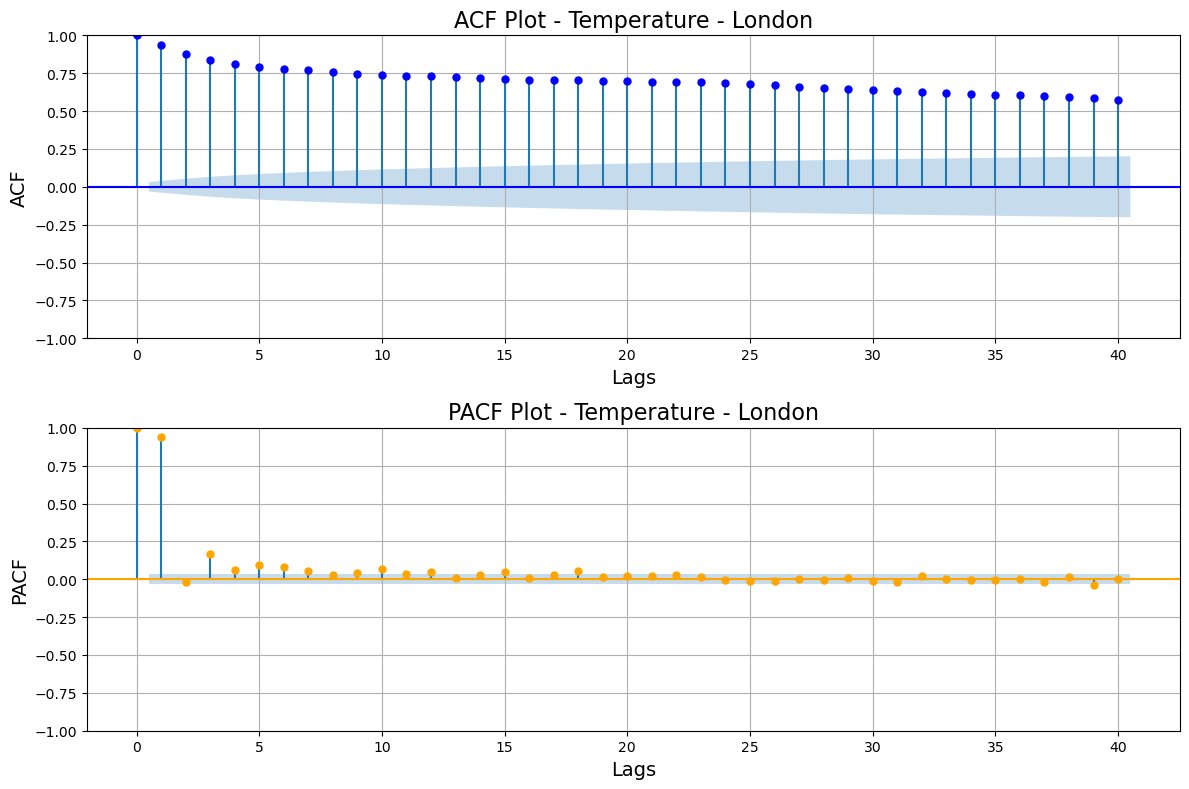

In [117]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF Plot
plot_acf(df_london['temp'], lags=40, ax=ax[0], color='blue', title='ACF Plot', alpha=0.05)
ax[0].set_title('ACF Plot - Temperature - London', fontsize=16)
ax[0].set_xlabel('Lags', fontsize=14)
ax[0].set_ylabel('ACF', fontsize=14)
ax[0].grid(True)

# PACF Plot
plot_pacf(df_london['temp'], lags=40, ax=ax[1], color='orange', title='PACF Plot', alpha=0.05)
ax[1].set_title('PACF Plot - Temperature - London', fontsize=16)
ax[1].set_xlabel('Lags', fontsize=14)
ax[1].set_ylabel('PACF', fontsize=14)
ax[1].grid(True)

plt.tight_layout()

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\ACF_PACF-London.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

### 4.1 Baseline model 

In [118]:
start_time = time.time()
model_sarimax_baseline = StatsmodelsSARIMAX(
    endog=df_train_short['temp'],
    exog=df_train_short.drop('temp',axis=1).astype(float),
    order=(1, 1, 1),  
    seasonal_order=(1, 1, 1, 12)  
)

In [119]:
sarimax_base_results = model_sarimax_baseline.fit()

end_time = time.time()
time_sarimax_baseline = end_time - start_time
print(f"Model execution time for SARIMAX baseline: {time_sarimax_baseline:.4f} seconds")

Model execution time for SARIMAX baseline: 26.6510 seconds


In [120]:
forecast_sarimax = sarimax_base_results.get_forecast(steps=len(df_test), exog=df_test.drop('temp',axis=1).astype(float))

In [121]:
forecast_sarimax.predicted_mean

2023-05-22    15.701231
2023-05-23    15.439488
2023-05-24    16.274314
2023-05-25    16.052129
2023-05-26    14.740708
                ...    
2024-05-16    60.305122
2024-05-17    60.777181
2024-05-18    60.639595
2024-05-19    60.068235
2024-05-20    59.786849
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [122]:
df_test_w_preds['preds_sarimax'] = forecast_sarimax.predicted_mean
df_test_w_preds.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive,naive_last,preds_autoarima,preds_sarimax
2023-05-22,15.1,6.9,64.3,0.0,0.0,0.0,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,12.189839,12.189839,13.984044,15.701231
2023-05-23,14.0,6.1,60.6,0.0,0.0,0.0,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,12.189839,12.189839,13.895126,15.439488
2023-05-24,15.8,6.7,61.2,0.0,0.0,0.0,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,12.189839,12.189839,13.759057,16.274314
2023-05-25,15.0,6.7,57.9,0.0,0.0,0.0,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,12.189839,12.189839,13.725513,16.052129
2023-05-26,14.2,6.9,63.5,0.0,0.0,0.0,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,12.189839,12.189839,13.632718,14.740708


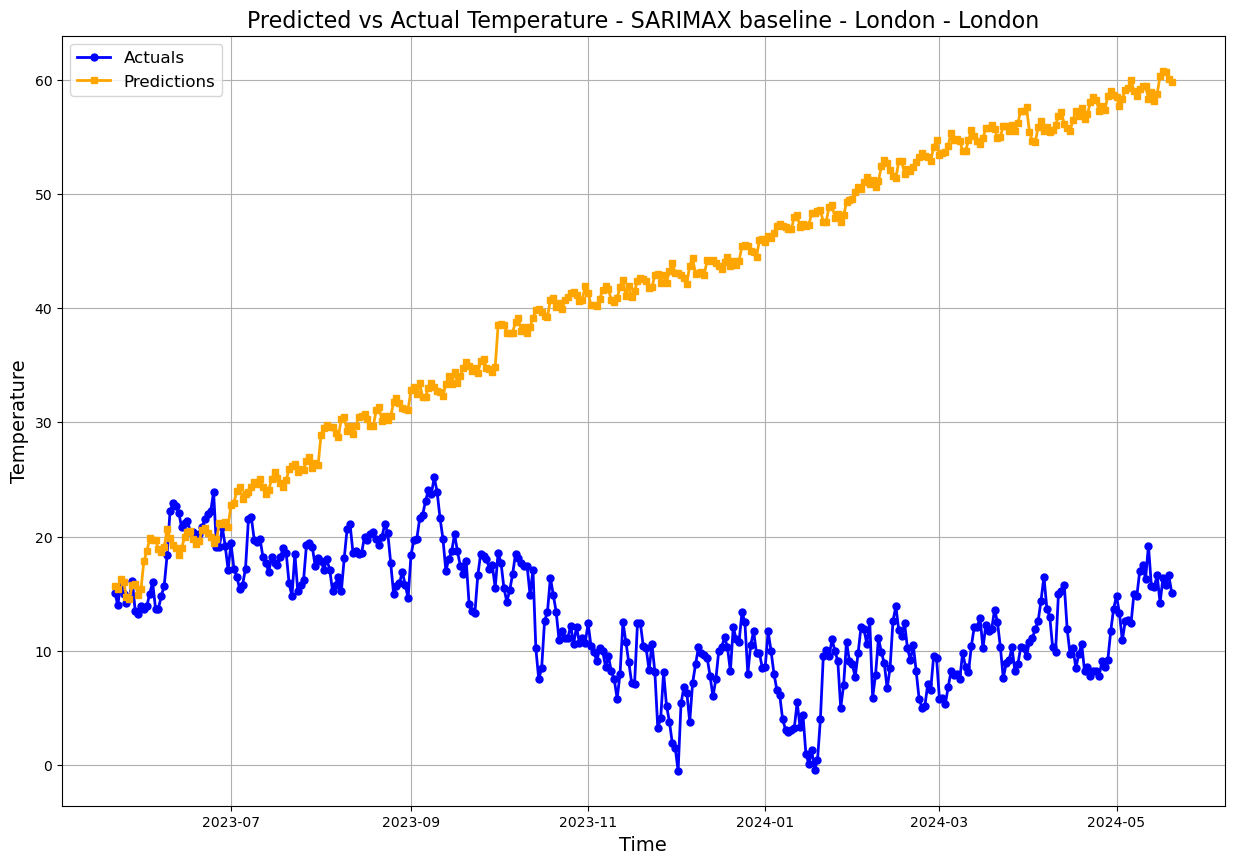

In [123]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds_sarimax']], 'SARIMAX baseline - London', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 4.2 SARIMAX baseline performance metrics

In [124]:
mae = mean_absolute_error(df_test['temp'], df_test_w_preds['preds_sarimax'])
mse = mean_squared_error(df_test['temp'], df_test_w_preds['preds_sarimax'])
rmse = np.sqrt(mse)
r2 = r2_score(df_test['temp'], df_test_w_preds['preds_sarimax'])

print(f"Mean Absolute Error (MAE) for SARIMAX: {mae}")
print(f"Mean Squared Error (MSE) for SARIMAX: {mse}")
print(f"Root Mean Squared Error (RMSE) for SARIMAX: {rmse}")
print(f"R-squared (R²) for SARIMAX: {r2}")

Mean Absolute Error (MAE) for SARIMAX: 28.00612873173098
Mean Squared Error (MSE) for SARIMAX: 1045.717374171902
Root Mean Squared Error (RMSE) for SARIMAX: 32.337553620703936
R-squared (R²) for SARIMAX: -36.939832749246925


### 4.3 SARIMAX GS

In [125]:
sarimax_results=df_test_w_preds.copy()

In [126]:
def gridsearch_sarimax(p,d,q,P,D,Q,S,df_results_sarimax): 
    start_time = time.time()
    print(p,d,q,P,D,Q,S)
    model_sarimax_baseline = StatsmodelsSARIMAX(
    endog=df_train_short['temp'],
    exog=df_train_short.drop('temp',axis=1).astype(float),
    order=(p,d,q),  
    seasonal_order=(P,D,Q,S))
    sarimax_base_results = model_sarimax_baseline.fit()
    forecast_sarimax = sarimax_base_results.get_forecast(steps=len(df_test), exog=df_test.drop('temp',axis=1).astype(float))
    df_results_sarimax[f"{p}_{d}_{q}_{P}_{D}_{Q}_{S}"]=forecast_sarimax.predicted_mean
    df_results_sarimax.to_csv(r"C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\sarimax_results.csv")
    end_time = time.time()
    time_sarimax_gs = end_time - start_time
    print(f"Model execution time for SARIMAX grid search: {time_sarimax_gs:.4f} seconds")
    return df_results_sarimax

In [127]:
p_values = range(0, 2)
d_values = [1]
q_values = range(0, 2)
P_values = range(0, 2)
D_values = [1]
Q_values = range(0, 2)
s_values = [12]

In [128]:
for p in p_values: 
    for d in d_values:
        for q in q_values: 
            for P in P_values: 
                for D in D_values: 
                    for Q in Q_values: 
                        for s in s_values:
                            sarimax_results = gridsearch_sarimax(p,d,q,P,D,Q,s,sarimax_results)



0 1 0 0 1 0 12
Model execution time for SARIMAX grid search: 12.0058 seconds
0 1 0 0 1 1 12
Model execution time for SARIMAX grid search: 22.7040 seconds
0 1 0 1 1 0 12
Model execution time for SARIMAX grid search: 21.8763 seconds
0 1 0 1 1 1 12
Model execution time for SARIMAX grid search: 25.7773 seconds
0 1 1 0 1 0 12
Model execution time for SARIMAX grid search: 9.2468 seconds
0 1 1 0 1 1 12
Model execution time for SARIMAX grid search: 25.9910 seconds
0 1 1 1 1 0 12
Model execution time for SARIMAX grid search: 22.9238 seconds
0 1 1 1 1 1 12
Model execution time for SARIMAX grid search: 24.3037 seconds
1 1 0 0 1 0 12
Model execution time for SARIMAX grid search: 7.7088 seconds
1 1 0 0 1 1 12
Model execution time for SARIMAX grid search: 23.7379 seconds
1 1 0 1 1 0 12
Model execution time for SARIMAX grid search: 24.7454 seconds
1 1 0 1 1 1 12
Model execution time for SARIMAX grid search: 21.8618 seconds
1 1 1 0 1 0 12
Model execution time for SARIMAX grid search: 9.1220 seconds
1 

In [129]:
sarimax_results.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive,naive_last,preds_autoarima,preds_sarimax,0_1_0_0_1_0_12,0_1_0_0_1_1_12,0_1_0_1_1_0_12,0_1_0_1_1_1_12,0_1_1_0_1_0_12,0_1_1_0_1_1_12,0_1_1_1_1_0_12,0_1_1_1_1_1_12,1_1_0_0_1_0_12,1_1_0_0_1_1_12,1_1_0_1_1_0_12,1_1_0_1_1_1_12,1_1_1_0_1_0_12,1_1_1_0_1_1_12,1_1_1_1_1_0_12,1_1_1_1_1_1_12
2023-05-22,15.1,6.9,64.3,0.0,0.0,0.0,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,12.189839,12.189839,13.984044,15.701231,14.262505,15.084606,16.262573,15.411402,14.014499,15.492858,16.140950,15.804579,14.121793,15.461941,16.230648,15.781626,13.779397,15.469442,15.974320,15.701231
2023-05-23,14.0,6.1,60.6,0.0,0.0,0.0,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,12.189839,12.189839,13.895126,15.439488,12.969671,14.858931,15.027297,15.335364,12.774197,15.358141,14.913157,15.525820,12.860826,15.273865,14.979103,15.505229,12.586652,15.237848,14.797642,15.439488
2023-05-24,15.8,6.7,61.2,0.0,0.0,0.0,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,12.189839,12.189839,13.759057,16.274314,11.726274,16.140163,14.934097,16.483676,11.545066,16.183049,14.830746,16.374834,11.622223,16.077460,14.884637,16.277457,11.392641,16.057595,14.677898,16.274314
2023-05-25,15.0,6.7,57.9,0.0,0.0,0.0,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,12.189839,12.189839,13.725513,16.052129,11.889092,15.489129,15.749994,15.788281,11.703066,15.760154,15.576497,16.164045,11.785514,15.716809,15.684872,16.048533,11.578694,15.647898,15.454353,16.052129
2023-05-26,14.2,6.9,63.5,0.0,0.0,0.0,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,12.189839,12.189839,13.632718,14.740708,13.688463,14.538317,15.236335,14.687503,13.499957,14.718160,15.108153,14.838604,13.578936,14.615004,15.198145,14.808915,13.408886,14.583778,14.971376,14.740708


In [130]:
# find the best SARIMAX GS to select one column 

In [131]:
for p in p_values: 
    for d in d_values:
        for q in q_values: 
            for P in P_values: 
                for D in D_values: 
                    for Q in Q_values: 
                        for s in s_values:
                            config = f"{p}_{d}_{q}_{P}_{D}_{Q}_{s}"
                            sarimax_results[f'ae_{config}'] = np.abs(sarimax_results['temp'] - sarimax_results[config])
                            #for each day it substracts the prediction from the actual temperature so it gets the error 

In [132]:
sarimax_results.head() #with the absolute error for all combos

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive,naive_last,preds_autoarima,preds_sarimax,0_1_0_0_1_0_12,0_1_0_0_1_1_12,0_1_0_1_1_0_12,0_1_0_1_1_1_12,0_1_1_0_1_0_12,0_1_1_0_1_1_12,0_1_1_1_1_0_12,0_1_1_1_1_1_12,1_1_0_0_1_0_12,1_1_0_0_1_1_12,1_1_0_1_1_0_12,1_1_0_1_1_1_12,1_1_1_0_1_0_12,1_1_1_0_1_1_12,1_1_1_1_1_0_12,1_1_1_1_1_1_12,ae_0_1_0_0_1_0_12,ae_0_1_0_0_1_1_12,ae_0_1_0_1_1_0_12,ae_0_1_0_1_1_1_12,ae_0_1_1_0_1_0_12,ae_0_1_1_0_1_1_12,ae_0_1_1_1_1_0_12,ae_0_1_1_1_1_1_12,ae_1_1_0_0_1_0_12,ae_1_1_0_0_1_1_12,ae_1_1_0_1_1_0_12,ae_1_1_0_1_1_1_12,ae_1_1_1_0_1_0_12,ae_1_1_1_0_1_1_12,ae_1_1_1_1_1_0_12,ae_1_1_1_1_1_1_12
2023-05-22,15.1,6.9,64.3,0.0,0.0,0.0,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,12.189839,12.189839,13.984044,15.701231,14.262505,15.084606,16.262573,15.411402,14.014499,15.492858,16.140950,15.804579,14.121793,15.461941,16.230648,15.781626,13.779397,15.469442,15.974320,15.701231,0.837495,0.015394,1.162573,0.311402,1.085501,0.392858,1.040950,0.704579,0.978207,0.361941,1.130648,0.681626,1.320603,0.369442,0.874320,0.601231
2023-05-23,14.0,6.1,60.6,0.0,0.0,0.0,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,12.189839,12.189839,13.895126,15.439488,12.969671,14.858931,15.027297,15.335364,12.774197,15.358141,14.913157,15.525820,12.860826,15.273865,14.979103,15.505229,12.586652,15.237848,14.797642,15.439488,1.030329,0.858931,1.027297,1.335364,1.225803,1.358141,0.913157,1.525820,1.139174,1.273865,0.979103,1.505229,1.413348,1.237848,0.797642,1.439488
2023-05-24,15.8,6.7,61.2,0.0,0.0,0.0,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,12.189839,12.189839,13.759057,16.274314,11.726274,16.140163,14.934097,16.483676,11.545066,16.183049,14.830746,16.374834,11.622223,16.077460,14.884637,16.277457,11.392641,16.057595,14.677898,16.274314,4.073726,0.340163,0.865903,0.683676,4.254934,0.383049,0.969254,0.574834,4.177777,0.277460,0.915363,0.477457,4.407359,0.257595,1.122102,0.474314
2023-05-25,15.0,6.7,57.9,0.0,0.0,0.0,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,12.189839,12.189839,13.725513,16.052129,11.889092,15.489129,15.749994,15.788281,11.703066,15.760154,15.576497,16.164045,11.785514,15.716809,15.684872,16.048533,11.578694,15.647898,15.454353,16.052129,3.110908,0.489129,0.749994,0.788281,3.296934,0.760154,0.576497,1.164045,3.214486,0.716809,0.684872,1.048533,3.421306,0.647898,0.454353,1.052129
2023-05-26,14.2,6.9,63.5,0.0,0.0,0.0,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,12.189839,12.189839,13.632718,14.740708,13.688463,14.538317,15.236335,14.687503,13.499957,14.718160,15.108153,14.838604,13.578936,14.615004,15.198145,14.808915,13.408886,14.583778,14.971376,14.740708,0.511537,0.338317,1.036335,0.487503,0.700043,0.518160,0.908153,0.638604,0.621064,0.415004,0.998145,0.608915,0.791114,0.383778,0.771376,0.540708


In [133]:
sarimax_results.mean()

temp                 12.998904
dew                   8.377260
humidity             75.371781
precip                1.770110
precipprob           59.178082
                       ...    
ae_1_1_0_1_1_1_12    28.091205
ae_1_1_1_0_1_0_12     4.393348
ae_1_1_1_0_1_1_12    24.759164
ae_1_1_1_1_1_0_12    29.614588
ae_1_1_1_1_1_1_12    28.006129
Length: 71, dtype: float64

In [134]:
sarimax_results.iloc[:, -16:].mean()

ae_0_1_0_0_1_0_12     5.655249
ae_0_1_0_0_1_1_12    11.234045
ae_0_1_0_1_1_0_12    32.784564
ae_0_1_0_1_1_1_12    17.499370
ae_0_1_1_0_1_0_12     4.017199
ae_0_1_1_0_1_1_12    25.624576
ae_0_1_1_1_1_0_12    31.228481
ae_0_1_1_1_1_1_12    28.492494
ae_1_1_0_0_1_0_12     4.565757
ae_1_1_0_0_1_1_12    25.542673
ae_1_1_0_1_1_0_12    32.174635
ae_1_1_0_1_1_1_12    28.091205
ae_1_1_1_0_1_0_12     4.393348
ae_1_1_1_0_1_1_12    24.759164
ae_1_1_1_1_1_0_12    29.614588
ae_1_1_1_1_1_1_12    28.006129
dtype: float64

## 5. LSTM (Long Short Term Memory)

### 5.1 Baseline model 

In [186]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(df_london[['temp']])

In [187]:
# the split_sequence function is from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

def split_sequence(sequence, n_steps):
    xs, ys = [], []
    for i in range(len(sequence) - n_steps):
        x = sequence[i:i + n_steps]
        y = sequence[i + n_steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [188]:
n_steps = 30
X_train, y_train= split_sequence(values, n_steps)
X_test, y_test = split_sequence(values, n_steps)

In [189]:
#number of steps will be the lagged features of 3

In [190]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [191]:
y_test #this is the series we're trying to predict, try to create a 3D feature set 

array([[0.25970149],
       [0.31940299],
       [0.32238806],
       ...,
       [0.56716418],
       [0.59104478],
       [0.54626866]])

In [192]:
# reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [193]:
model_baseline = Sequential()
model_baseline.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))
model_baseline.add(LSTM(50))
model_baseline.add(Dense(1))
model_baseline.compile(optimizer='adam', loss='mean_squared_error')

In [194]:
start_time = time.time()

model_baseline.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

end_time = time.time()
time_lstm_baseline = end_time - start_time
print(f"Model training time for LSTM baseline: {time_lstm_baseline:.2f} seconds")

Epoch 1/10
118/118 [==============================] - 7s 28ms/step - loss: 0.0133 - val_loss: 0.0066
Epoch 2/10
118/118 [==============================] - 2s 17ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 3/10
118/118 [==============================] - 4s 32ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 4/10
118/118 [==============================] - 2s 19ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 5/10
118/118 [==============================] - 2s 19ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 6/10
118/118 [==============================] - 2s 18ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/10
118/118 [==============================] - 2s 18ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 8/10
118/118 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/10
118/118 [==============================] - 2s 19ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 10/10
118/118 [==============================] - 2s 19ms/step - loss: 0.0032 - val_lo

In [195]:
def predict_future(model, data, n_steps, predict_n_days):
    prediction_list = data[-n_steps:].tolist()
    prediction_list = [item[0] for item in prediction_list]
    
    for _ in range(predict_n_days):
        x = np.array(prediction_list[-n_steps:]).reshape((1, n_steps, 1))
        out = model.predict(x)[0][0]
        prediction_list.append(out)

    # transforms the predictions back to the original scale
    prediction_list = scaler.inverse_transform(np.array(prediction_list).reshape(-1, 1))
    return prediction_list

In [196]:
predict_n_days = 365

In [197]:
yhat_baseline = predict_future(model_baseline, values, n_steps, predict_n_days)

1/1 [==============================] - 0s 23ms/step


In [198]:
yhat_baseline[n_steps:]

array([[15.92222353],
       [16.9383405 ],
       [17.76112162],
       [18.40828209],
       [18.95739986],
       [19.45753523],
       [19.92264749],
       [20.3890896 ],
       [20.84943362],
       [21.3194599 ],
       [21.80041243],
       [22.28131305],
       [22.78082742],
       [23.2870429 ],
       [23.80954792],
       [24.34597232],
       [24.89937114],
       [25.4720646 ],
       [26.05802252],
       [26.66187735],
       [27.2836311 ],
       [27.92145874],
       [28.56980928],
       [29.22638645],
       [29.90482809],
       [30.61402576],
       [31.35165923],
       [32.08834623],
       [32.85948126],
       [33.62353181],
       [34.4387592 ],
       [35.26547592],
       [36.09653758],
       [36.93345373],
       [37.8037756 ],
       [38.66093086],
       [39.56885563],
       [40.45268356],
       [41.35641514],
       [42.29091274],
       [43.23834132],
       [44.15332662],
       [45.08559184],
       [46.04801606],
       [46.98884736],
       [47

In [199]:
len(yhat_baseline[n_steps:])

365

In [200]:
df_test_w_preds['lstm_base'] = yhat_baseline[n_steps:]
df_test_w_preds.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive,naive_last,preds_autoarima,preds_sarimax,lstm_base,lstm_two_layers,lstm_two_layers_batch_size_1,lstm_features,sarimax_gs
2023-05-22,15.1,6.9,64.3,0.0,0.0,0.0,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,12.189839,12.189839,13.984044,15.701231,15.922224,15.368996,13.841642,12.066167,1.085501
2023-05-23,14.0,6.1,60.6,0.0,0.0,0.0,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,12.189839,12.189839,13.895126,15.439488,16.938341,15.308199,13.047831,12.066167,1.225803
2023-05-24,15.8,6.7,61.2,0.0,0.0,0.0,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,12.189839,12.189839,13.759057,16.274314,17.761122,15.238746,12.342554,12.066167,4.254934
2023-05-25,15.0,6.7,57.9,0.0,0.0,0.0,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,12.189839,12.189839,13.725513,16.052129,18.408282,15.167250,11.648980,12.066167,3.296934
2023-05-26,14.2,6.9,63.5,0.0,0.0,0.0,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,12.189839,12.189839,13.632718,14.740708,18.957400,15.097821,10.958488,12.066167,0.700043


In [201]:
# the model is very weak and needs improving with additional layers

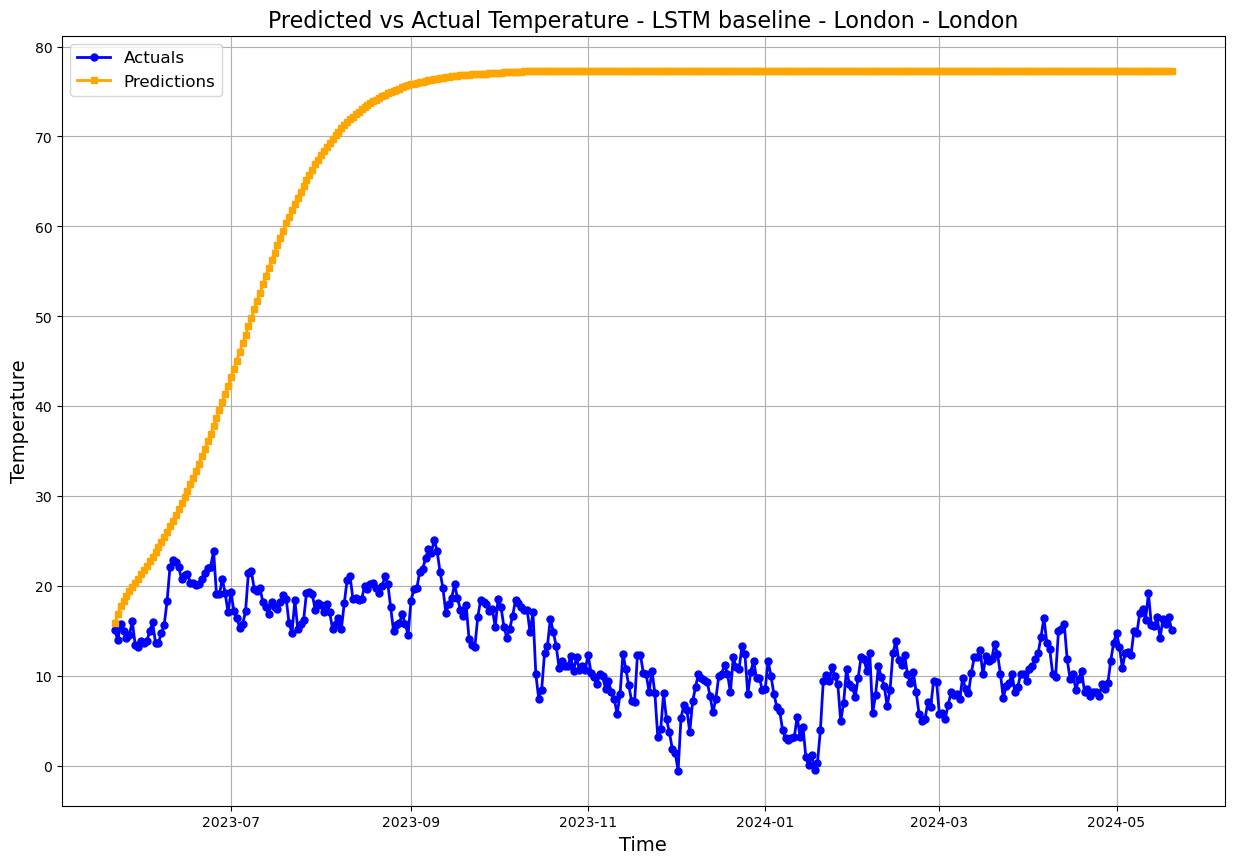

In [202]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['lstm_base']], 'LSTM baseline - London', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 5.2 LSTM baseline performance metrics

In [203]:
y_true = df_test_w_preds['temp'].values  
y_pred = df_test_w_preds['lstm_base'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared Score (R²): {r2:.2f}')

Mean Absolute Error (MAE): 56.66
Mean Squared Error (MSE): 3569.64
Root Mean Squared Error (RMSE): 59.75
Mean Absolute Percentage Error (MAPE): 966.67%
R-squared Score (R²): -128.51


### 5.3 Improved layers - LSTM

In [204]:
model_lstm_two = Sequential()
model_lstm_two.add(LSTM(100, return_sequences=True, input_shape=(n_steps, 1)))
model_lstm_two.add(Dropout(0.2))

model_lstm_two.add(LSTM(100, return_sequences=False))
model_lstm_two.add(Dropout(0.2))

model_lstm_two.add(Dense(50, activation='relu'))

model_lstm_two.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model_lstm_two.compile(optimizer=optimizer, loss='mean_squared_error')

start_time = time.time()
history = model_lstm_two.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))
end_time = time.time()
time_lstm_layers = end_time - start_time
print(f"Model training time: {time_lstm_layers:.2f} seconds")

Epoch 1/3
118/118 [==============================] - 6s 24ms/step - loss: 0.0146 - val_loss: 0.0067
Epoch 2/3
118/118 [==============================] - 2s 17ms/step - loss: 0.0077 - val_loss: 0.0063
Epoch 3/3
118/118 [==============================] - 2s 17ms/step - loss: 0.0071 - val_loss: 0.0060
Model training time: 10.00 seconds


In [205]:
yhat_lstm_two = predict_future(model_lstm_two, values, n_steps, predict_n_days)

1/1 [==============================] - 0s 28ms/step


In [206]:
df_test_w_preds['lstm_two_layers'] = yhat_lstm_two[n_steps:]
df_test_w_preds.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive,naive_last,preds_autoarima,preds_sarimax,lstm_base,lstm_two_layers,lstm_two_layers_batch_size_1,lstm_features,sarimax_gs
2023-05-22,15.1,6.9,64.3,0.0,0.0,0.0,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,12.189839,12.189839,13.984044,15.701231,15.922224,16.320464,13.841642,12.066167,1.085501
2023-05-23,14.0,6.1,60.6,0.0,0.0,0.0,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,12.189839,12.189839,13.895126,15.439488,16.938341,16.355573,13.047831,12.066167,1.225803
2023-05-24,15.8,6.7,61.2,0.0,0.0,0.0,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,12.189839,12.189839,13.759057,16.274314,17.761122,16.423521,12.342554,12.066167,4.254934
2023-05-25,15.0,6.7,57.9,0.0,0.0,0.0,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,12.189839,12.189839,13.725513,16.052129,18.408282,16.508858,11.648980,12.066167,3.296934
2023-05-26,14.2,6.9,63.5,0.0,0.0,0.0,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,12.189839,12.189839,13.632718,14.740708,18.957400,16.600729,10.958488,12.066167,0.700043


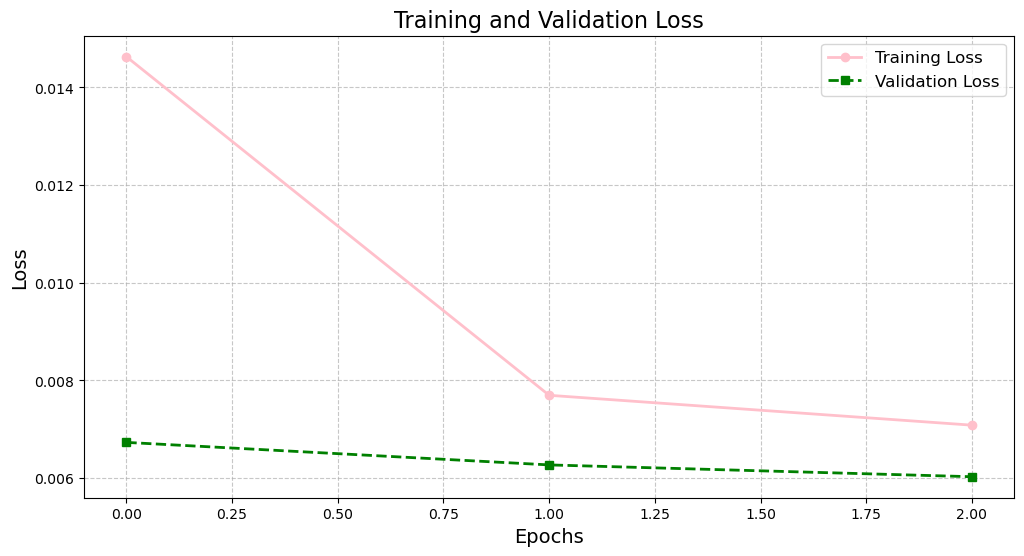

In [207]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='pink', linestyle='-', linewidth=2, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green', linestyle='--', linewidth=2, marker='s')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\LSTM_baseline_training_loss.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

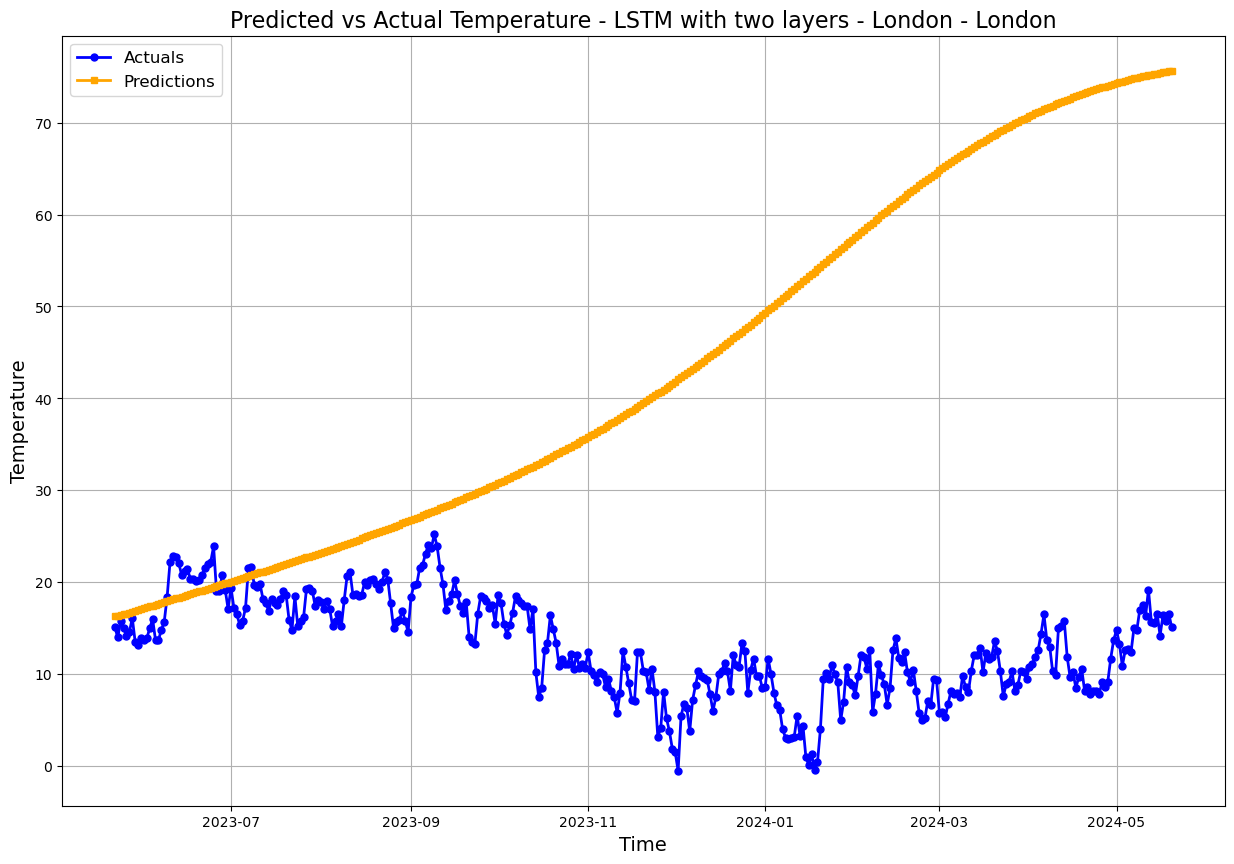

In [208]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['lstm_two_layers']], 'LSTM with two layers - London', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 5.4 LSTM improved layers performance metrics

In [209]:
y_true = df_test_w_preds['temp'].values
y_pred_lstm_two = df_test_w_preds['lstm_two_layers'].values

mae_value_lstm_two = mean_absolute_error(y_true, y_pred_lstm_two)
mse_value_lstm_two = mean_squared_error(y_true, y_pred_lstm_two)
rmse_value_lstm_two = np.sqrt(mse_value_lstm_two)
mape_value_lstm_two = np.mean(np.abs((y_true - y_pred_lstm_two) / y_true)) * 100
r2_value_lstm_two = r2_score(y_true, y_pred_lstm_two)

print(f'Mean Absolute Error (MAE): {mae_value_lstm_two:.2f}')
print(f'Mean Squared Error (MSE): {mse_value_lstm_two:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value_lstm_two:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value_lstm_two:.2f}%')
print(f'R-squared Score (R²): {r2_value_lstm_two:.2f}')

Mean Absolute Error (MAE): 30.61
Mean Squared Error (MSE): 1442.59
Root Mean Squared Error (RMSE): 37.98
Mean Absolute Percentage Error (MAPE): 604.63%
R-squared Score (R²): -51.34


### 5.5 Tuning batch size for LSTM

In [210]:
start_time = time.time()
history_batchsize_1 = model_lstm_two.fit(X_train, y_train, epochs=3, batch_size=1, validation_data=(X_test, y_test))
end_time = time.time()
time_lstm_batch = end_time - start_time
print(f"Model training time for LSTM batch: {time_lstm_batch:.2f} seconds")

Epoch 1/3
3763/3763 [==============================] - 65s 17ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 2/3
3763/3763 [==============================] - 69s 18ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 3/3
3763/3763 [==============================] - 65s 17ms/step - loss: 0.0040 - val_loss: 0.0041
Model training time for LSTM batch: 198.67 seconds


In [211]:
yhat_lstm_batch_1 = predict_future(model_lstm_two, values, n_steps, predict_n_days)


1/1 [==============================] - 0s 32ms/step


In [212]:
df_test_w_preds['lstm_two_layers_batch_size_1'] = yhat_lstm_batch_1[n_steps:]


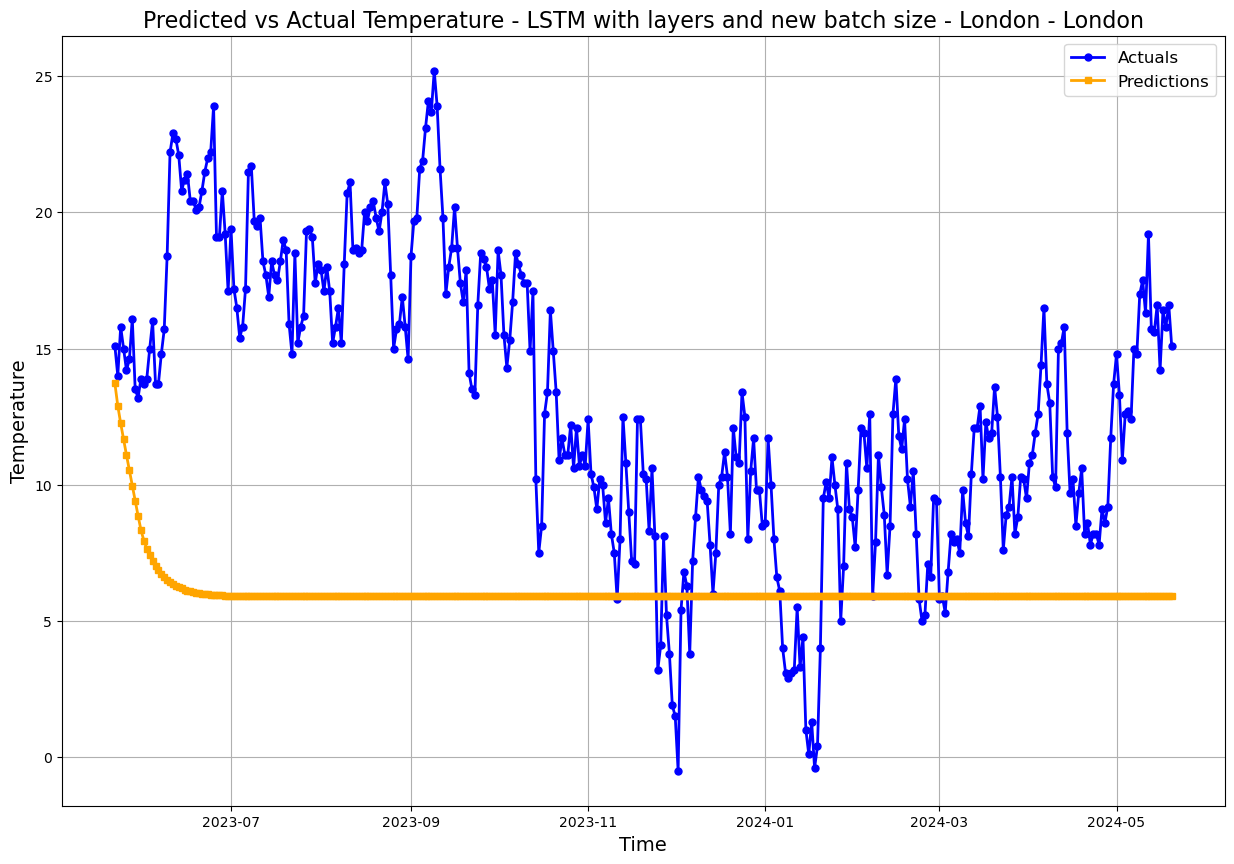

In [213]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['lstm_two_layers_batch_size_1']], 'LSTM with layers and new batch size - London', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 5.6. Batch size LSTM performance metrics

In [214]:
y_true = df_test_w_preds['temp'].values 
y_pred_lstm_batch_1 = df_test_w_preds['lstm_two_layers_batch_size_1'].values

mae_value_lstm_batch_1 = mean_absolute_error(y_true, y_pred_lstm_batch_1)
mse_value_lstm_batch_1 = mean_squared_error(y_true, y_pred_lstm_batch_1)
rmse_value_lstm_batch_1 = np.sqrt(mse_value_lstm_batch_1)
mape_value_lstm_batch_1 = np.mean(np.abs((y_true - y_pred_lstm_batch_1) / y_true)) * 100
r2_value_lstm_batch_1 = r2_score(y_true, y_pred_lstm_batch_1)

print(f'Mean Absolute Error (MAE): {mae_value_lstm_batch_1:.2f}')
print(f'Mean Squared Error (MSE): {mse_value_lstm_batch_1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value_lstm_batch_1:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value_lstm_batch_1:.2f}%')
print(f'R-squared Score (R²): {r2_value_lstm_batch_1:.2f}')

Mean Absolute Error (MAE): 7.33
Mean Squared Error (MSE): 75.43
Root Mean Squared Error (RMSE): 8.69
Mean Absolute Percentage Error (MAPE): 80.34%
R-squared Score (R²): -1.74


### 5.7 LSTM with added features

In [215]:
def split_sequence(features, target, n_steps):
    xs, ys = [], []
    
    # loop through the data to create sequences
    for i in range(len(features) - n_steps):
        # extract sequences of features and the corresponding target
        x = features[i:i + n_steps]
        y = target[i + n_steps]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)


In [216]:
df_train = df_train.astype(float)
df_test = df_test.astype(float)

In [217]:
X_train, y_train= split_sequence(df_train.drop(['temp'], axis=1),df_train['temp'], n_steps)
X_test, y_test = split_sequence(df_test.drop(['temp'], axis=1),df_test['temp'], n_steps)

In [218]:
model_lstm_features = Sequential()
model_lstm_features.add(LSTM(100, return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model_lstm_features.add(Dropout(0.2))

model_lstm_features.add(LSTM(100, return_sequences=False))
model_lstm_features.add(Dropout(0.2))

model_lstm_features.add(Dense(50, activation='relu'))

model_lstm_features.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model_lstm_features.compile(optimizer=optimizer, loss='mean_squared_error')

start_time = time.time()
history = model_lstm_features.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))
end_time = time.time()
time_lstm_features = end_time - start_time
print(f"Model training time for LSTM with features: {time_lstm_features:.2f} seconds")

Epoch 1/3
107/107 [==============================] - 5s 21ms/step - loss: 43.4449 - val_loss: 27.3309
Epoch 2/3
107/107 [==============================] - 1s 14ms/step - loss: 29.2883 - val_loss: 28.5020
Epoch 3/3
107/107 [==============================] - 2s 19ms/step - loss: 29.2203 - val_loss: 27.5440
Model training time for LSTM with features: 8.93 seconds


In [219]:
def get_predictions(model, X_test):
    predictions = model.predict(X_test)
    
    # since the model outputs a 2D array (batch_size, 1), we'll flatten it to match the shape of the y_test
    return predictions.flatten()


In [220]:
preds = np.concatenate([X_train[-30:], X_test])

In [221]:
predictions = get_predictions(model_lstm_features, preds)


12/12 [==============================] - 1s 6ms/step


In [222]:
predictions

array([12.122518 , 12.121412 , 12.130052 , 12.121359 , 12.132952 ,
       12.121784 , 12.133077 , 12.124282 , 12.120551 , 12.1200285,
       12.119988 , 12.134578 , 12.138795 , 12.134303 , 12.122207 ,
       12.134857 , 12.138864 , 12.128454 , 12.121105 , 12.133233 ,
       12.121842 , 12.132133 , 12.138077 , 12.139456 , 12.122645 ,
       12.120347 , 12.134598 , 12.1388035, 12.139641 , 12.139622 ,
       12.139842 , 12.139842 , 12.139842 , 12.139075 , 12.139608 ,
       12.139833 , 12.139855 , 12.139848 , 12.139842 , 12.139842 ,
       12.139842 , 12.124235 , 12.13543  , 12.138465 , 12.13804  ,
       12.139383 , 12.139757 , 12.12275  , 12.134827 , 12.138811 ,
       12.139655 , 12.12274  , 12.134763 , 12.13881  , 12.139621 ,
       12.139834 , 12.139852 , 12.122674 , 12.134969 , 12.138892 ,
       12.139675 , 12.139836 , 12.139853 , 12.139838 , 12.13984  ,
       12.12296  , 12.135083 , 12.122252 , 12.134852 , 12.138857 ,
       12.122694 , 12.126548 , 12.135232 , 12.138752 , 12.1225

In [223]:
df_test_w_preds['temp'].values

array([15.1, 14. , 15.8, 15. , 14.2, 14.6, 16.1, 13.5, 13.2, 13.9, 13.7,
       13.9, 15. , 16. , 13.7, 13.7, 14.8, 15.7, 18.4, 22.2, 22.9, 22.7,
       22.1, 20.8, 21.2, 21.4, 20.4, 20.4, 20.1, 20.2, 20.8, 21.5, 22. ,
       22.2, 23.9, 19.1, 19.1, 20.8, 19.2, 17.1, 19.4, 17.2, 16.5, 15.4,
       15.8, 17.2, 21.5, 21.7, 19.7, 19.5, 19.8, 18.2, 17.7, 16.9, 18.2,
       17.7, 17.5, 18.2, 19. , 18.6, 15.9, 14.8, 18.5, 15.2, 15.8, 16.2,
       19.3, 19.4, 19.1, 17.4, 18.1, 17.9, 17.1, 18. , 17.1, 15.2, 15.8,
       16.5, 15.2, 18.1, 20.7, 21.1, 18.6, 18.7, 18.5, 18.6, 20. , 19.7,
       20.2, 20.4, 19.8, 19.3, 20. , 21.1, 20.3, 17.7, 15. , 15.7, 15.9,
       16.9, 15.8, 14.6, 18.4, 19.7, 19.8, 21.6, 21.9, 23.1, 24.1, 23.7,
       25.2, 23.9, 21.6, 19.8, 17. , 18. , 18.7, 20.2, 18.7, 17.4, 16.7,
       17.9, 14.1, 13.5, 13.3, 16.6, 18.5, 18.3, 18. , 17.2, 17.5, 15.5,
       18.6, 17.7, 15.5, 14.3, 15.3, 16.7, 18.5, 18.1, 17.7, 17.4, 17.4,
       14.9, 17.1, 10.2,  7.5,  8.5, 12.6, 13.4, 16

In [224]:
df_test_w_preds['lstm_features'] = predictions


In [225]:
df_test_w_preds[['temp','lstm_features']]

,temp,lstm_features
2023-05-22,15.1,12.122518
2023-05-23,14.0,12.121412
2023-05-24,15.8,12.130052
2023-05-25,15.0,12.121359
2023-05-26,14.2,12.132952
...,...,...
2024-05-16,14.2,12.139615
2024-05-17,16.4,12.122834
2024-05-18,15.8,12.120339
2024-05-19,16.6,12.121518


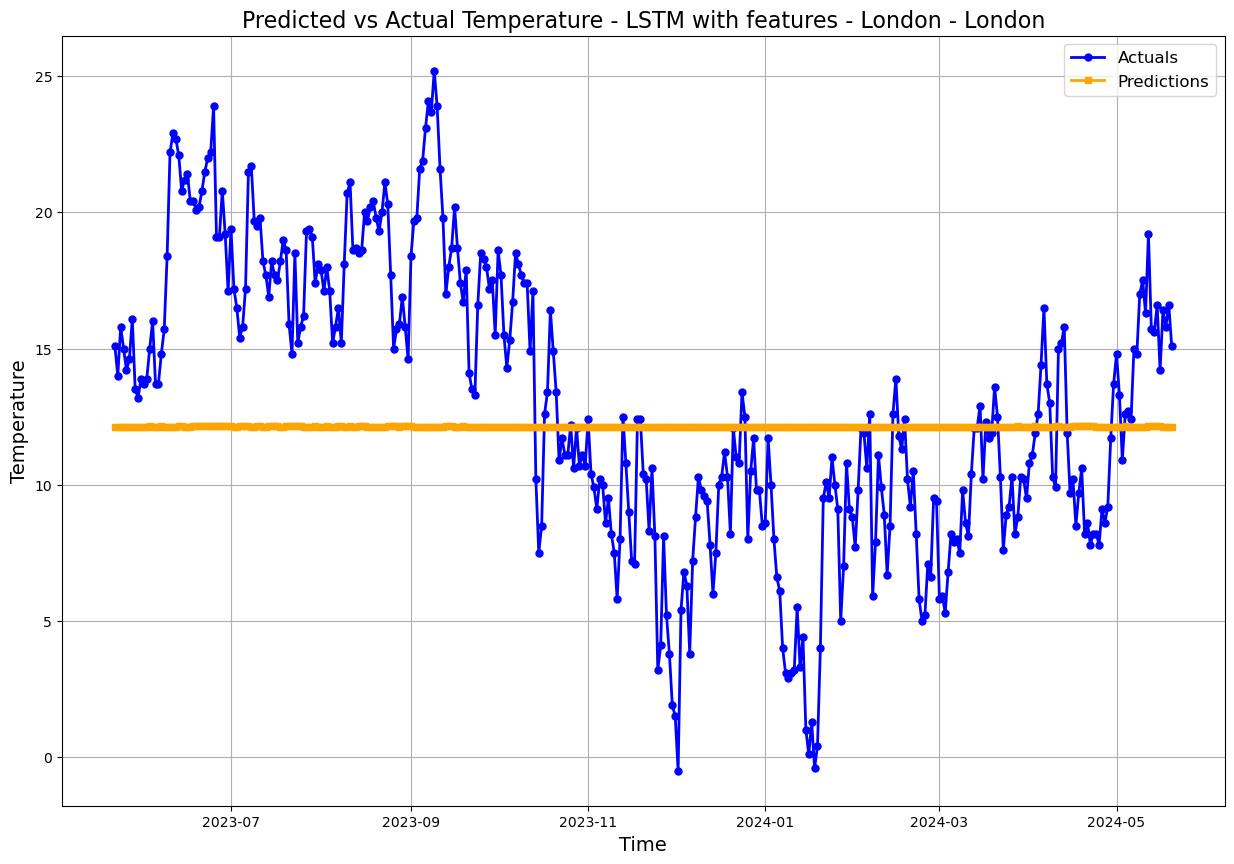

In [226]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['lstm_features']], 'LSTM with features - London', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

In [227]:
#performance metrics

In [228]:
y_true = df_test_w_preds['temp'].values  
y_pred_lstm_features = df_test_w_preds['lstm_features'].values

mae_value_lstm_features = mean_absolute_error(y_true, y_pred_lstm_features)
mse_value_lstm_features = mean_squared_error(y_true, y_pred_lstm_features)
rmse_value_lstm_features = np.sqrt(mse_value_lstm_features)
mape_value_lstm_features = np.mean(np.abs((y_true - y_pred_lstm_features) / y_true)) * 100
r2_value_lstm_features = r2_score(y_true, y_pred_lstm_features)

print(f'Mean Absolute Error (MAE): {mae_value_lstm_features:.2f}')
print(f'Mean Squared Error (MSE): {mse_value_lstm_features:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value_lstm_features:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value_lstm_features:.2f}%')
print(f'R-squared Score (R²): {r2_value_lstm_features:.2f}')

Mean Absolute Error (MAE): 4.42
Mean Squared Error (MSE): 28.28
Root Mean Squared Error (RMSE): 5.32
Mean Absolute Percentage Error (MAPE): 103.77%
R-squared Score (R²): -0.03


## 6. Concatenating final SARIMAX results in the df with all predictions

In [229]:
df_test_w_preds['sarimax_gs'] = sarimax_results['ae_0_1_1_0_1_0_12']

In [230]:
# ae_0_1_1_0_1_0_12 is the best combination of parameters 

In [231]:
df_test_w_preds.to_csv(r"C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\df_with_all_preds.csv")

## 7. Time all models

In [232]:
# defining the results of the Naive Forecaster GS and the SARIMAX GS since they have multiple outputs 

time_nf_mean = 0.1341
time_nf_drift = 0.1911
time_nf_last = 0.0208 

#best combination of the SARIMAX GS outputs
time_sarimax_best = 12.5681 

In [233]:
execution_times = {
    'XGBoost Baseline': time_xgboost_baseline, 
    'XGBoost Grid search': time_xgboost_gs, 
    'Naive Forecaster Baseline': time_naive_baseline,
    'Naive Forecaster Mean strategy': time_nf_mean,
    'Naive Forecaster Drift strategy': time_nf_drift,
    'Naive Forecaster Last strategy': time_nf_last,
    'Auto-ARIMA': time_autoarima_baseline,
    'SARIMAX Baseline': time_sarimax_baseline,
    'SARIMAX Best combination': time_sarimax_best,
    'LSTM Baseline': time_lstm_baseline,
    'LSTM Improved Layers': time_lstm_layers,
    'LSTM Batch Size': time_lstm_batch,
    'LSTM with features': time_lstm_features
}

time_results = pd.DataFrame(list(execution_times.items()), columns=['Model', 'Execution Time (seconds)'])

In [234]:
time_results

,Model,Execution Time (seconds)
0,XGBoost Baseline,0.334746
1,XGBoost Grid search,23.837852
2,Naive Forecaster Baseline,0.003000
3,Naive Forecaster Mean strategy,0.134100
4,Naive Forecaster Drift strategy,0.191100
5,Naive Forecaster Last strategy,0.020800
6,Auto-ARIMA,68.547173
7,SARIMAX Baseline,26.651019
8,SARIMAX Best combination,12.568100
9,LSTM Baseline,27.875698


In [235]:
# pip freeze > requirements.txt